In [1]:
from pandas import json_normalize
import pandas as pd
import json

In [2]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from tqdm.notebook import tqdm

def flattened_idx_to_layer_head(flattened_idx, num_heads):
    return flattened_idx // num_heads, flattened_idx % num_heads

def layer_head_to_flattened_idx(layer, head, num_heads):
    return layer * num_heads + head

def get_top_heads(train_idxs, val_idxs, separated_activations, separated_labels, num_layers, num_heads, seed, num_to_intervene, use_random_dir=False, specific_heads = None):

    probes, all_head_accs_np, train_accs = train_probes(seed, train_idxs, val_idxs, separated_activations, separated_labels, num_layers=num_layers, num_heads=num_heads)
    all_head_accs_np = all_head_accs_np.reshape(num_layers, num_heads)

    if specific_heads is not None:
        top_heads = [layer_head_to_flattened_idx(head[0], head[1], num_heads) for head in specific_heads]
        
    else:
        
        top_heads = []
        top_accs = np.argsort(all_head_accs_np.reshape(num_heads*num_layers))[::-1][:num_to_intervene]
        print(top_accs)
        #print(top_accs[0:5])
        top_heads = [flattened_idx_to_layer_head(idx, num_heads) for idx in top_accs]
    if use_random_dir: 
        # overwrite top heads with random heads, no replacement
        random_idxs = np.random.choice(num_heads*num_layers, num_heads*num_layers, replace=False)
        top_heads = [flattened_idx_to_layer_head(idx, num_heads) for idx in random_idxs[:num_to_intervene]]

    return top_heads, probes

def get_interventions_dict(top_heads, probes, tuning_activations, num_heads, use_center_of_mass, use_random_dir, com_directions): 

    interventions = {}
    for layer, head in top_heads: 
        interventions[f"model.layers.{layer}.self_attn.head_out"] = []
    for layer, head in top_heads:
        if use_center_of_mass: 
            direction = com_directions[layer_head_to_flattened_idx(layer, head, num_heads)]
        elif use_random_dir: 
            direction = np.random.normal(size=(128,))
        else: 
            direction = probes[layer_head_to_flattened_idx(layer, head, num_heads)].coef_
        direction = direction / np.linalg.norm(direction)
        activations = tuning_activations[:,layer,head,:] # batch x 128
        proj_vals = activations @ direction.T
        proj_val_std = np.std(proj_vals)
        interventions[f"model.layers.{layer}.self_attn.head_out"].append((head, direction.squeeze(), proj_val_std))
        
    for layer, head in top_heads: 
        interventions[f"model.layers.{layer}.self_attn.head_out"] = sorted(interventions[f"model.layers.{layer}.self_attn.head_out"], key = lambda x: x[0])

    return interventions

### New activations

In [3]:
df = pd.read_json("requirements_data/dataframe_open_chat_cot_moon_06022024_attentions_gt.json")

df.reset_index(drop=True, inplace=True)
correct = [0 if value == "yes" else 1 for value in df.predict.values]
df.correct = correct

In [4]:
import numpy as np 

index_dic = {}
separated_activations = []
separated_labels = []
reqs_order = []
for req_id in df['req_id'].unique():

    req_df = df[df['req_id'] == req_id].index

    #req_ids.append(req_df)
    index_dic[req_id] = list(req_df)
    
    temp_activations = df[df['req_id'] == req_id].attentions
    activations = np.array([list(sample.values()) for sample in temp_activations.values])#.shape
    batch_length = len(temp_activations)
    dim = 128
    activations = np.reshape(activations, (batch_length, 32, 32, dim))

    temp_labels = [1 if label==True else 0 for label in df[df['req_id'] == req_id]['correct'].values]
    separated_labels.append(temp_labels)
    separated_activations.append(activations)
    reqs_order.append(req_id)

number_of_examples = np.arange(len(reqs_order))

In [11]:
from sklearn.linear_model import LogisticRegression

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.svm import SVC

def remove_outliers(tuning_data, filter_data, labels, threshold = 4):

    # Calculate mean and standard deviation
    means = tuning_data.mean(axis=0)
    stds = tuning_data.std(axis=0)

    # Calculate z-scores
    z_scores = np.abs((filter_data - means) / stds)

    # Set a threshold
    threshold = threshold

    # Find where all features have a z-score less than the threshold
    non_outliers = (z_scores < threshold).all(axis=1)

    # Filter out the outliers
    filtered_data = filter_data[non_outliers]
    filter_labels = labels[non_outliers]
    #print(filter_data.shape)
    #print(filter_labels.shape)
    return filtered_data, filter_labels


In [12]:
from dataclasses import dataclass
import numpy as np
@dataclass
class Args:
    #model_name: str
    #dataset_name: str
    #activations_dataset: str
    val_ratio: float
    use_center_of_mass: bool
    use_random_dir: bool
    seed: int
    num_heads: int

args = Args(val_ratio=0.5, use_center_of_mass=False, use_random_dir=False, seed=42, num_heads=12)

num_layers =32
num_heads = 32

seed = 42

fold_results = []
fold_probes = []

# get two folds using numpy
num_fold = 1
fold_idxs = np.array_split(number_of_examples, num_fold)
for i in range(len(fold_idxs)):
    print(i)
    if num_fold == 1: 
        train_idxs = np.arange(len(reqs_order))
    else:
        train_idxs = np.concatenate([fold_idxs[j] for j in range(num_fold) if j != i])

    val_ratio = args.val_ratio
    seed = 42  # You can choose your own seed value
    rng = np.random.default_rng(seed)
    size = int(len(train_idxs)*(1-val_ratio))
    #print(size)
    train_set_idxs = rng.choice(train_idxs, size=size, replace=False)
    val_set_idxs = np.array([x for x in train_idxs if x not in train_set_idxs])

    if len(fold_idxs) == 1:
        test_idxs = val_set_idxs
    else:
        test_idxs = fold_idxs[i]

    print(fold_idxs)
    print(train_idxs)
    print("Train indexes:" , train_set_idxs)
    print("Validation indexes: ", val_set_idxs)
    #print(test_idxs)

    train_index_list = np.concatenate([list(index_dic.values())[i] for i in train_set_idxs], axis = 0)
    train_set = df.loc[train_index_list]

    rng = np.random.default_rng(seed)
    val_idxs = val_set_idxs
    

0
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Train indexes: [17 34  5 31 38 25  4  1 15 18 24  2 39 22 29 32 28 10 19 16]
Validation indexes:  [ 0  3  6  7  8  9 11 12 13 14 20 21 23 26 27 30 33 35 36 37]


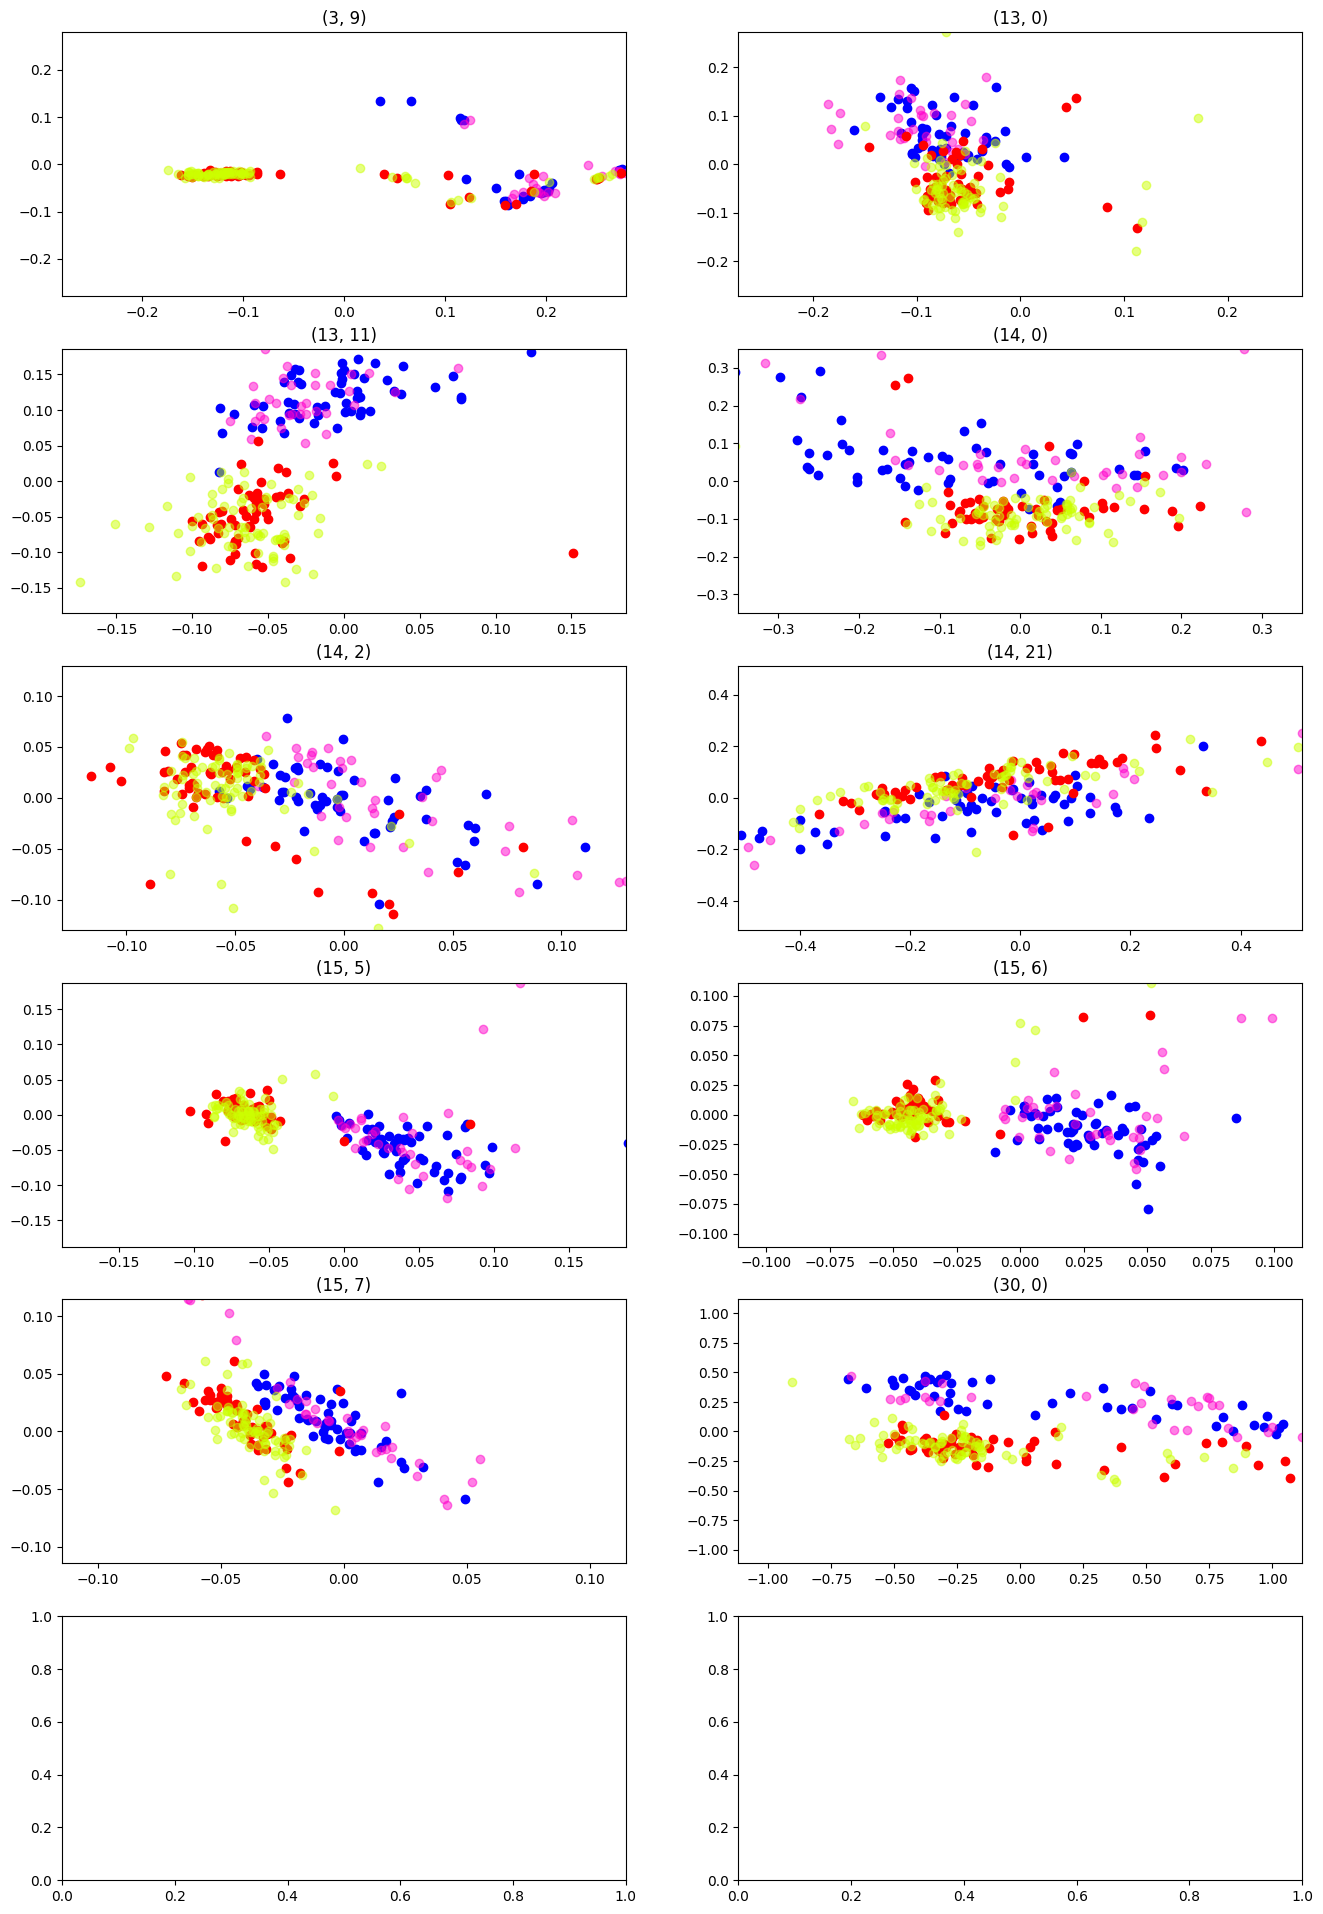

In [24]:
from sklearn.cluster import KMeans
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import colorsys

from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
#heads = [(13,0), (13,11), (31,14), (30,0), (11,8), (8,24), (7,24), (10, 23), (17,23), (18,0)]
#heads = [(4,31), (15,2), (13,0), (10,23), (15,3),(3,6),(9,17), (13,19),(3,14), (7,14)]
#heads = [(2,7), (13,0), (13,11), (2,6)]
#heads = [(13, 0), (13, 8), (13, 11), (0, 31), (1, 0), (3, 9), (7, 24), (10, 23), (15, 2), (17, 23), (28, 8), (30, 0), (31, 13), (31, 14), (31, 28), (31, 30)]
heads = [(3,9), (13,0), (13,11),(14,0), (14,2), (14,21), (15,5), (15,6),(15,7), (30,0)]
n_rows = len(heads) // 2 + 1
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(16, 24))

def adjust_hue_saturation_lightness_from_name(color_name, hue_shift, saturation_scale, lightness_scale):
    # Convert color name to RGB
    rgb_color = mcolors.to_rgb(color_name)
    
    # Convert RGB to HLS
    h, l, s = colorsys.rgb_to_hls(*rgb_color)
    
    # Adjust Hue, Lightness, and Saturation
    h = (h + hue_shift) % 1.0
    l = max(0, min(1, l * lightness_scale))
    s = max(0, min(1, s * saturation_scale))
    
    # Convert back to RGB
    adjusted_color = colorsys.hls_to_rgb(h, l, s)
    return adjusted_color

dim_reduction = True
rm_outliers= True
for id, head in enumerate(heads):

    ax = fig.axes[id] 
    ax.set_title(str(head))

    layer = head[0]
    h = head[1]
    all_X_train = np.concatenate([separated_activations[i] for i in train_set_idxs], axis = 0)
    #print(all_X_train.shape)
    all_X_val = np.concatenate([separated_activations[i] for i in val_set_idxs], axis = 0)
    y_train = np.concatenate([separated_labels[i] for i in train_set_idxs], axis = 0)
    #print(y_train.shape)
    y_val = np.concatenate([separated_labels[i] for i in val_set_idxs], axis = 0)

    X_train = all_X_train[:,layer,h,:]
    #print(X_train.shape)
    X_val = all_X_val[:,layer,h,:]
    #print(X_val.shape)
    

    dim_reduction = PCA(n_components = 2, random_state=22).fit(X_train)
    X_train_transform = dim_reduction.transform(X_train)
    X_val_transform = dim_reduction.transform(X_val)
            
    #### CAREFUL PCA IS ON
    if dim_reduction: 
        X_train = X_train_transform
        X_val = X_val_transform

    tresh= 2
    if rm_outliers:

                X_val, y_val = remove_outliers(X_train, X_val, y_val, threshold= tresh)
                X_train, y_train = remove_outliers(X_train, X_train, y_train, threshold=tresh)

    # Setting up the plot limits and labels
    ax.set_xlim([-X_train.max(), X_train.max()])
    ax.set_ylim([-X_train.max(), X_train.max()])

    
    for label, color in zip([True, False], ['blue', 'red']):
            indexes_val = np.where(y_val== label)[0]
            #samples = [X_val_reduction[i] for i in indexes_val]
            for idx in indexes_val:
                ax.scatter(X_val[idx,0], X_val[idx, 1], color=color, label=str(idx), alpha=1)

            indexes_train = np.where(y_train == label)[0]
            #samples = [X_val_reduction[i] for i in indexes_val]
            # Adjust the hue by 0.1, increase lightness by 20%, and keep the same saturation
            color = adjust_hue_saturation_lightness_from_name(color, 0.2, 1.0, 1)
            for idx in indexes_train:

                ax.scatter(X_train[idx,0], X_train[idx, 1], color=color, label=str(idx), alpha=0.5)

        

In [9]:
def remove_outliers(tuning_data, filter_data, labels):

    # Calculate mean and standard deviation
    means = tuning_data.mean(axis=0)
    stds = tuning_data.std(axis=0)

    # Calculate z-scores
    z_scores = np.abs((filter_data - means) / stds)

    # Set a threshold
    threshold = 4

    # Find where all features have a z-score less than the threshold
    non_outliers = (z_scores < threshold).all(axis=1)

    # Filter out the outliers
    filtered_data = filter_data[non_outliers]
    filter_labels = labels[non_outliers]
    #print(filter_data.shape)
    #print(filter_labels.shape)
    return filtered_data, filter_labels

[3.23787943 1.70460388]
90.0
[3.51083664 1.24226107]
90.0
[ 3.72840897 -0.1990281 ]
90.0
[0.68175292 3.50227394]
90.0
[3.71771948 0.55920434]
90.0
[0.06876047 1.91110007]
90.0


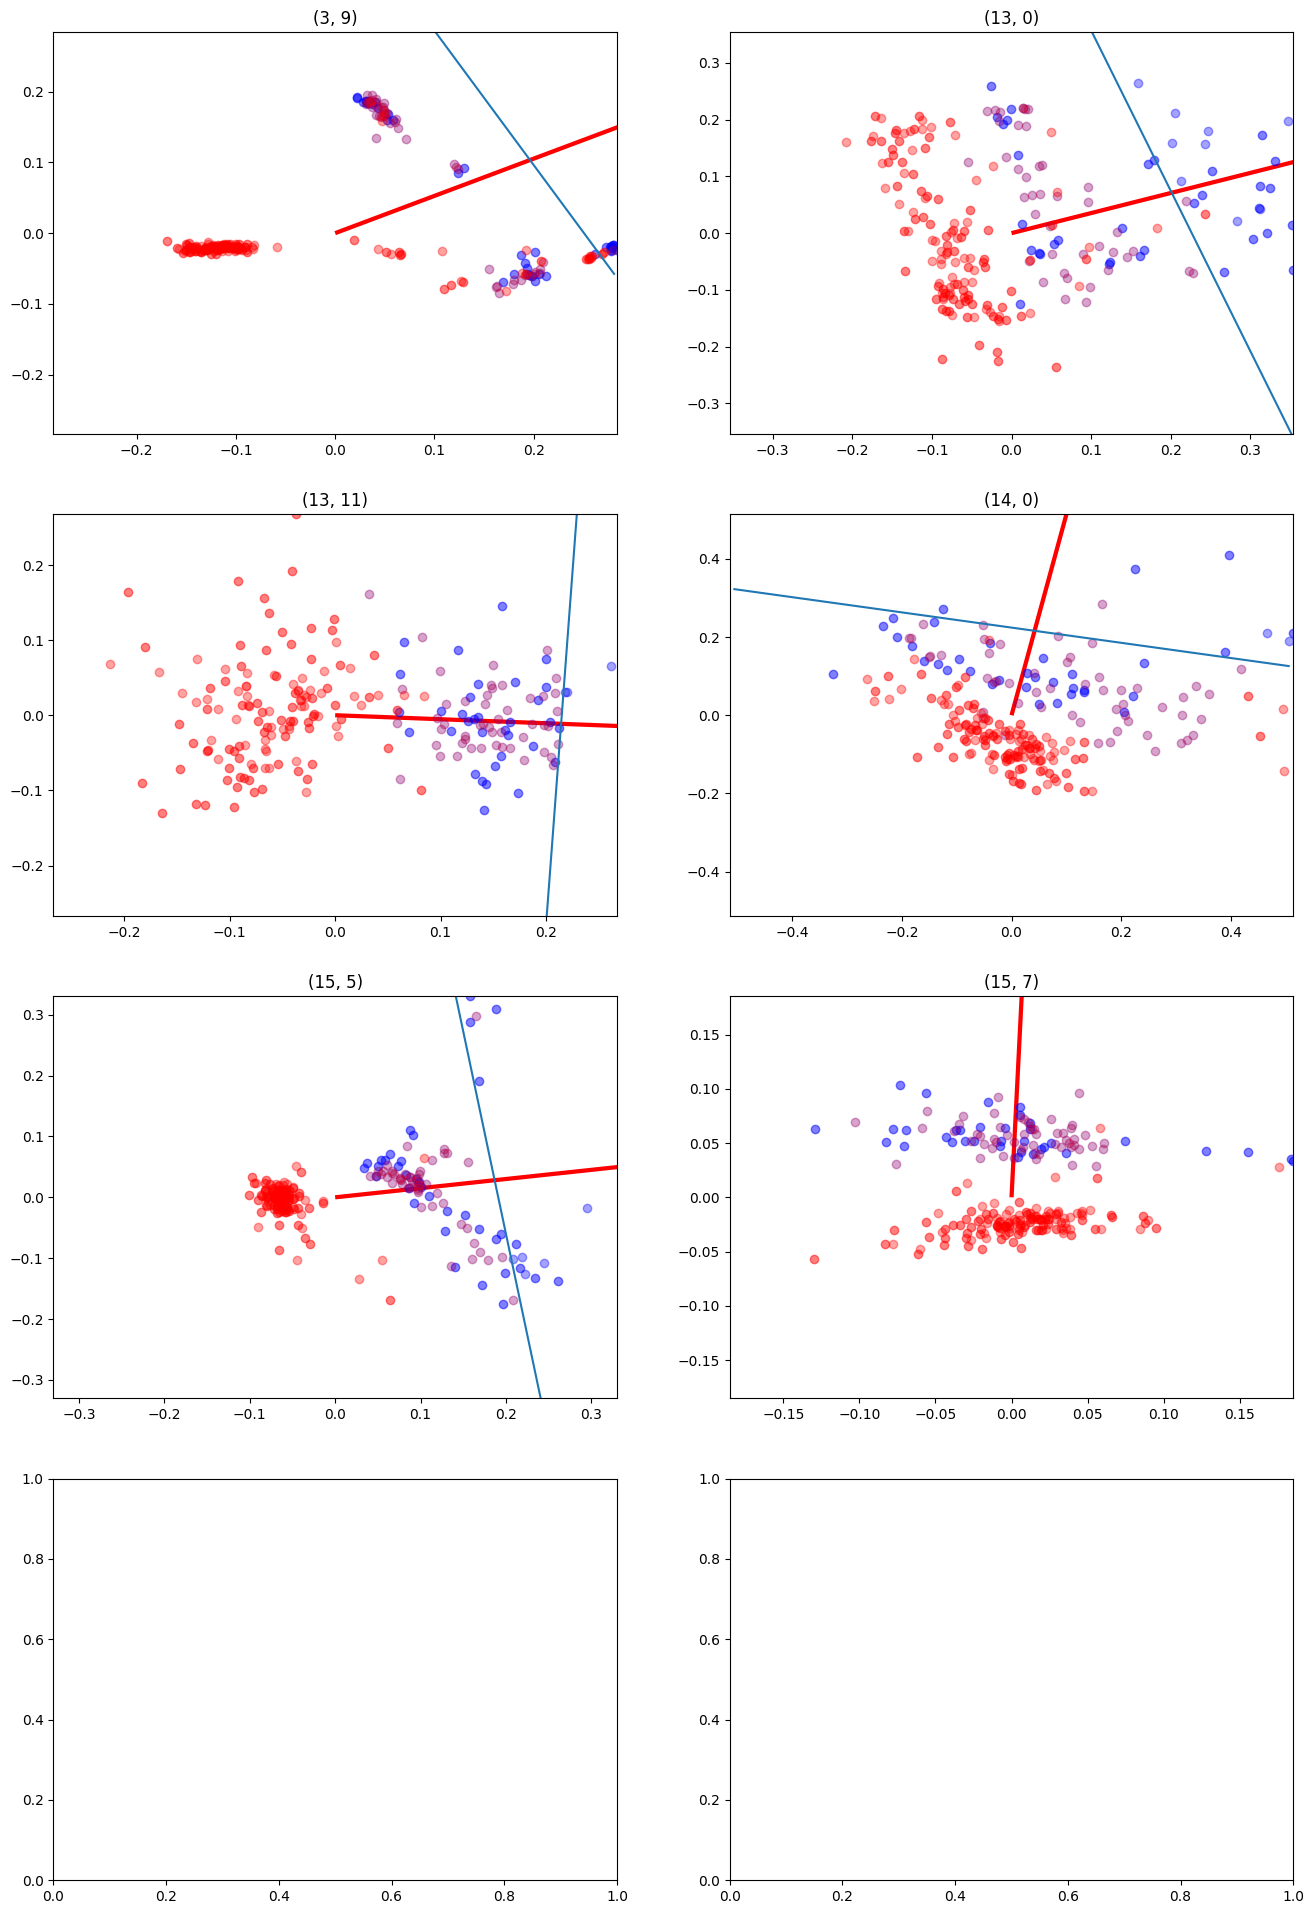

In [20]:
from sklearn.cluster import KMeans
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import colorsys

from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
#heads = [(13,0), (13,11), (31,14), (30,0), (11,8), (8,24), (7,24), (10, 23), (17,23), (18,0)]
#heads = [(4,31), (15,2), (13,0), (10,23), (15,3),(3,6),(9,17), (13,19),(3,14), (7,14)]
#heads = [(2,7), (13,0), (13,11), (2,6)]
#heads = [(13, 0), (13, 8), (13, 11), (0, 31), (1, 0), (3, 9), (7, 24), (10, 23), (15, 2), (17, 23), (28, 8), (30, 0), (31, 13), (31, 14), (31, 28), (31, 30)]
heads = [(3,9), (13,0), (13,11),(14,0), (15,5), (15,7)]
n_rows = len(heads) // 2 + 1
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(16, 24))

def adjust_hue_saturation_lightness_from_name(color_name, hue_shift, saturation_scale, lightness_scale):
    # Convert color name to RGB
    rgb_color = mcolors.to_rgb(color_name)
    
    # Convert RGB to HLS
    h, l, s = colorsys.rgb_to_hls(*rgb_color)
    
    # Adjust Hue, Lightness, and Saturation
    h = (h + hue_shift) % 1.0
    l = max(0, min(1, l * lightness_scale))
    s = max(0, min(1, s * saturation_scale))
    
    # Convert back to RGB
    adjusted_color = colorsys.hls_to_rgb(h, l, s)
    return adjusted_color


def angle_between_vectors_degrees(u, v):
    dot_product = np.dot(u, v)
    norms = np.linalg.norm(u) * np.linalg.norm(v)
    rad = np.arccos(dot_product / norms)  # Calculate the angle in radians
    deg = np.degrees(rad)  # Convert to degrees
    return deg

dim_reduction = True
rm_outliers = True
for id, head in enumerate(heads):

    ax = fig.axes[id] 
    ax.set_title(str(head))

    layer = head[0]
    h = head[1]
    all_X_train = np.concatenate([separated_activations[i] for i in train_set_idxs], axis = 0)
    #print(all_X_train.shape)
    all_X_val = np.concatenate([separated_activations[i] for i in val_set_idxs], axis = 0)
    y_train = np.concatenate([separated_labels[i] for i in train_set_idxs], axis = 0)
    #print(y_train.shape)
    y_val = np.concatenate([separated_labels[i] for i in val_set_idxs], axis = 0)

    X_train = all_X_train[:,layer,h,:]
    #print(X_train.shape)
    X_val = all_X_val[:,layer,h,:]
    #print(X_val.shape)


    # # Filtering for outliers
    if rm_outliers:

        X_val, y_val = remove_outliers(X_train, X_val, y_val)
        X_train, y_train = remove_outliers(X_train, X_train, y_train)

    dim_reduction = PCA(n_components = 2).fit(X_train)
    X_train_transform = dim_reduction.transform(X_train)
    X_val_transform = dim_reduction.transform(X_val)
            
    #### CAREFUL PCA IS ON
    if dim_reduction: 
        X_train = X_train_transform
        X_val = X_val_transform

    # Specify the number of clusters
    #cl = KMeans(n_clusters=2, random_state=24, n_init="auto").fit(X_train)
    cl = probes[layer_head_to_flattened_idx(layer, h,32)]
    # The KMeans inertia attribute represents WCSS
    #wcss = cl.inertia_

    #print(f"Within-Cluster Sum of Squares (WCSS): {wcss} for layer {layer} and head {h}")

    # Here you add the silhouette score calculation
    # Calculate the silhouette score using the fit_predict method on X_train

    #X_reduction = cl.transform(X_train)
    #sil_score = silhouette_score(X_train, cl.labels_)
    #db_score = davies_bouldin_score(X_train, cl.labels_)
    #print(f"Silhouette Score: {sil_score} for layer {layer} and head {h}")
    #print(f"Davies-Bouldin Score: {db_score} for layer {layer} and head {h}")
    

    # Origin of the vector
    origin = [0], [0]  # origin point
    coef = cl.coef_[0]
    print(coef)
    intercept = cl.intercept_
    x = coef[0]
    y = coef[1]
    #ax.quiver(*origin, -coef[1], coef[0], scale=5, color='r')

    # # intercept = 0  # Assuming the intercept is 0; replace it with your classifier's intercept if available
    # # Generating a range of x1 values to cover the range of your data or the range you're interested in
    # x1_values = np.linspace(X_val.min(), X_val.max(), 400)
    # # Calculating the corresponding x2 values for the hyperplane
    # x2_values = -(coef[0]/ coef[1]) * x1_values #- (intercept / coef[1])
    # x3_values = (coef[1]/ coef[0]) * x1_values
    
    # # Plotting the vector of coefficients
    # ax.quiver(*origin, coef[0], coef[1], scale=1, color='r')
    # ax.plot(x1_values, x3_values, label='Normal Vector')
    # ax.plot(x1_values, x2_values, label='Decision Boundary')

    # Generate a range for the x-axis
    x1 = np.linspace(-X_val.max(), X_val.max(), 400)
    #x1 = np.linspace(-5, 5, 100)
    # Calculate the perpendicular line's y values using the perpendicular slope -x/y
    x2 = (-x / y) * x1 - intercept / y

    x3 = (y/x) * x1

    # Plotting
    #fig, ax = plt.subplots()
    ax.plot(x1, x2, label='Perpendicular Line')
    #ax.plot(x1, x3, label='Perpendicular Line')
    #ax.quiver(0, intercept, x, y, angles='xy', scale_units='xy', scale=5, color='r', label='Vector v')
    ax.quiver(0, 0, x, y, angles='xy', scale_units='xy', scale=5, color='r', label='Vector v')
    
    #ax.quiver(0, 0, -y, x, angles='xy', scale_units='xy', scale=1, color='r', label='Vector u')

    vector_a = np.array([x, y])
    vector_b = np.array([-y, x])    
    print(angle_between_vectors_degrees(vector_a, vector_b))

    # # Setting up the plot limits and labels
    # ax.set_xlim([-X_val.max(), X_val.max()])
    # ax.set_ylim([-X_val.max(), X_val.max()])

    ax.set_xlim([-X_train.max(), X_train.max()])
    ax.set_ylim([-X_train.max(), X_train.max()])


    y_val_predict = cl.predict(X_val)
    for label, color in zip([True, False], ['blue', 'red']):
            
            indexes_train = np.where(y_train == label)[0]
            #samples = [X_val_reduction[i] for i in indexes_val]

            for idx in indexes_train:

                ax.scatter(X_train[idx,0], X_train[idx, 1], color=color, label=str(idx), alpha=0.5)


            indexes_true = np.where(y_val== label)[0]
            for idx in indexes_true:
                ax.scatter(X_val[idx,0], X_val[idx, 1], color=color, label=str(idx), alpha=0.2)

            indexes_predict = np.where(y_val_predict == label)[0]
            #samples = [X_val_reduction[i] for i in indexes_val]
            # Adjust the hue by 0.1, increase lightness by 20%, and keep the same saturation
            #color = adjust_hue_saturation_lightness_from_name(color, 0.2, 1.0, 1)
            for idx in indexes_predict:
                 ax.scatter(X_val[idx,0], X_val[idx, 1], color=color, label=str(idx), alpha=0.2)

In [98]:
cl.intercept_

array([-0.76104948])

In [92]:
vector_a = cl.coef_[0] ##np.array([2, 5])
vector_b = np.array([-vector_a[1], vector_a[0]])
print(vector_a)
print(vector_b)
# Function to calculate the angle between vectors in degrees
def angle_between_vectors_degrees(u, v):
    dot_product = np.dot(u, v)
    norms = np.linalg.norm(u) * np.linalg.norm(v)
    rad = np.arccos(dot_product / norms)  # Calculate the angle in radians
    deg = np.degrees(rad)  # Convert to degrees
    return deg

angle = angle_between_vectors_degrees(vector_a, vector_b)
angle

[ 0.64743091 -0.83664449]
[0.83664449 0.64743091]


90.0

[ 0.64743091 -0.83664449]
[0.83664449 0.64743091]


In [91]:

    # # intercept = 0  # Assuming the intercept is 0; replace it with your classifier's intercept if available
    # # Generating a range of x1 values to cover the range of your data or the range you're interested in
    # x1_values = np.linspace(X_val.min(), X_val.max(), 400)
    # # Calculating the corresponding x2 values for the hyperplane
    # x2_values = -(coef[0]/ coef[1]) * x1_values #- (intercept / coef[1])
    # x3_values = (coef[1]/ coef[0]) * x1_values
    
    # # Plotting the vector of coefficients
    # ax.quiver(*origin, coef[0], coef[1], scale=1, color='r')
    # ax.plot(x1_values, x3_values, label='Normal Vector')
    # ax.plot(x1_values, x2_values, label='Decision Boundary')

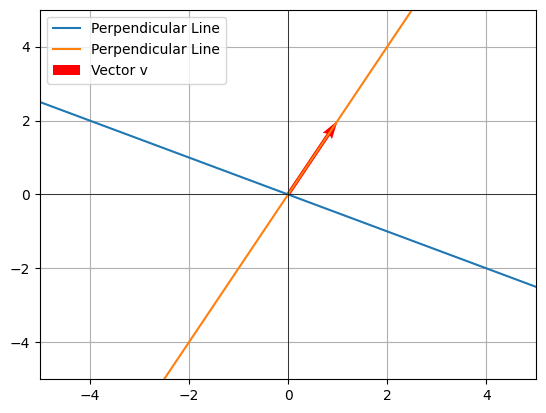

In [79]:
import numpy as np
import matplotlib.pyplot as plt

# Your vector v = (x, y)
x, y = 1, 2  # Example vector components

# Generate a range for the x-axis
x1 = np.linspace(-5, 5, 100)
# Calculate the perpendicular line's y values using the perpendicular slope -x/y
x2 = (-x / y) * x1

x3 = (y/x) * x1

# Plotting
fig, ax = plt.subplots()
ax.plot(x1, x2, label='Perpendicular Line')
ax.plot(x1, x3, label='Perpendicular Line')

ax.quiver(0, 0, x, y, angles='xy', scale_units='xy', scale=1, color='r', label='Vector v')

# Setting up the plot limits and labels
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
ax.axhline(0, color='black',linewidth=0.5)
ax.axvline(0, color='black',linewidth=0.5)
ax.grid(True, which='both')
ax.legend()

plt.show()


In [71]:
vector

In [56]:
cl.coef_

array([[ 0.64743091, -0.83664449]])

In [52]:
cl._intercept

AttributeError: 'LogisticRegression' object has no attribute '_intercept'

In [20]:
indexes_predict = np.where(y_val_predict == label)[0]
indexes_predict

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114])

#### Plot according to Train / Valid split 

(185, 32, 32, 128)
(185,)
(185, 32, 32, 128)
(185,)
(185, 32, 32, 128)
(185,)
(185, 32, 32, 128)
(185,)


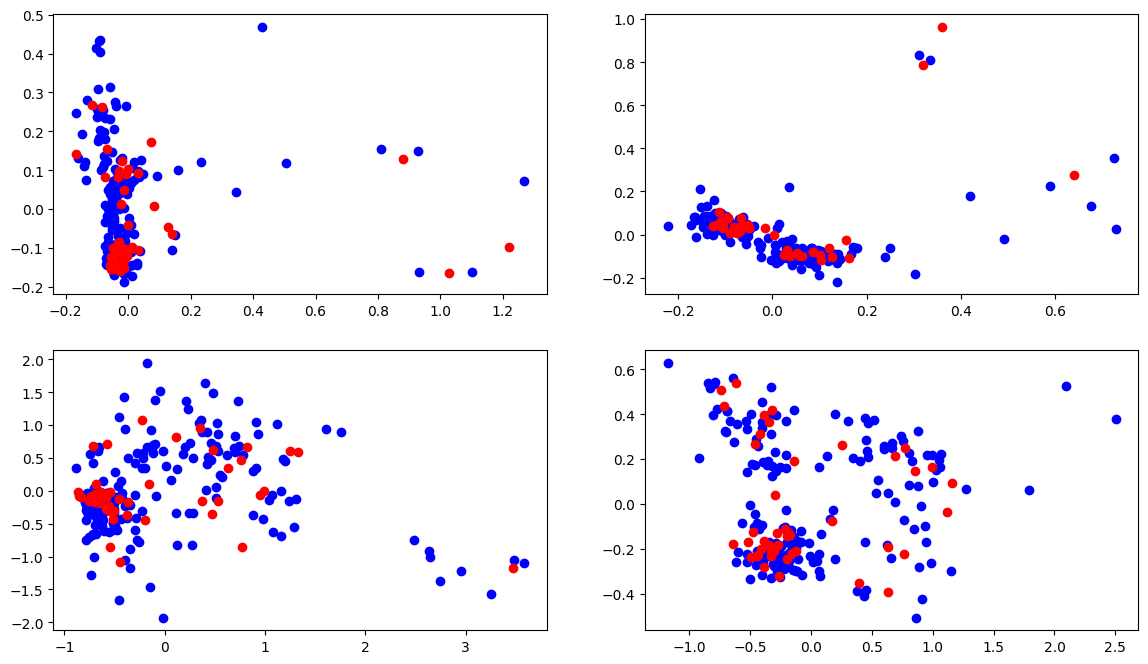

In [14]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np 
import matplotlib.pyplot as plt

heads = [(13,0), (13,11), (31,14), (30,0)]
#for head in heads:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8)) 

for id, head in enumerate(heads):

    ax = fig.axes[id] 
    layer = head[0]
    h = head[1]
    all_X_train = np.concatenate([separated_activations[i] for i in train_set_idxs], axis = 0)
    print(all_X_train.shape)
    all_X_val = np.concatenate([separated_activations[i] for i in val_set_idxs], axis = 0)
    y_train = np.concatenate([separated_labels[i] for i in train_set_idxs], axis = 0)
    print(y_train.shape)
    y_val = np.concatenate([separated_labels[i] for i in val_set_idxs], axis = 0)

    X_train = all_X_train[:,layer,h,:]
    X_train.shape

    X_val = all_X_val[:,layer,h,:]
    X_val.shape


    #cl = TSNE(n_components=2, random_state=args.seed).fit(X_train)
    cl = PCA(n_components=2, random_state=args.seed).fit(X_train)

    X_reduction = cl.transform(X_train)
    X_val_reduction = cl.transform(X_val)
    color = ['blue', 'red']
    ax.scatter(X_reduction[:,0], X_reduction[:,1], c=color[0])#, label=str(label))

    ax.scatter(X_val_reduction[:,0], X_val_reduction[:,1], c=color[1])
    



#### Silhouette score

In [81]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
X, y = make_blobs(random_state=42)
#kmeans = KMeans(n_clusters=2, random_state=42)
#silhouette_score(X, kmeans.fit_predict(X))

In [84]:
#kmeans.fit_predict(X)

In [38]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
all_X_train = np.concatenate([separated_activations[i] for i in train_set_idxs], axis = 0)
#print(all_X_train.shape)
all_X_val = np.concatenate([separated_activations[i] for i in val_set_idxs], axis = 0)
y_train = np.concatenate([separated_labels[i] for i in train_set_idxs], axis = 0)
#print(y_train.shape)
y_val = np.concatenate([separated_labels[i] for i in val_set_idxs], axis = 0)

num_layers = 32
num_heads = 32
sil_scores = []
ars = []
for layer in tqdm(range(num_layers)): 
    for h in range(num_heads): 
        X_train = all_X_train[:,layer,h,:]
        X_train.shape

        X_val = all_X_val[:,layer,h,:]

        
        # Specify the number of clusters
        cl = KMeans(n_clusters=2, random_state=24, n_init="auto").fit(X_train)
        X_reduction = cl.transform(X_train)
        sil_score = silhouette_score(X_train, cl.labels_)
        predict = cl.predict(X_val)
        adj_rand_index = adjusted_rand_score(y_val, predict)
        sil_scores.append(sil_score)
        ars.append(adj_rand_index)
        #print(f"Silhouette Score: {sil_score} for layer {layer} and head {h}")
    


  0%|          | 0/32 [00:00<?, ?it/s]

In [40]:
sil_scores = np.array(sil_scores)
ars = np.array(ars)
#sil_scores[0:5]

Text(0, 0.5, 'Row Index')

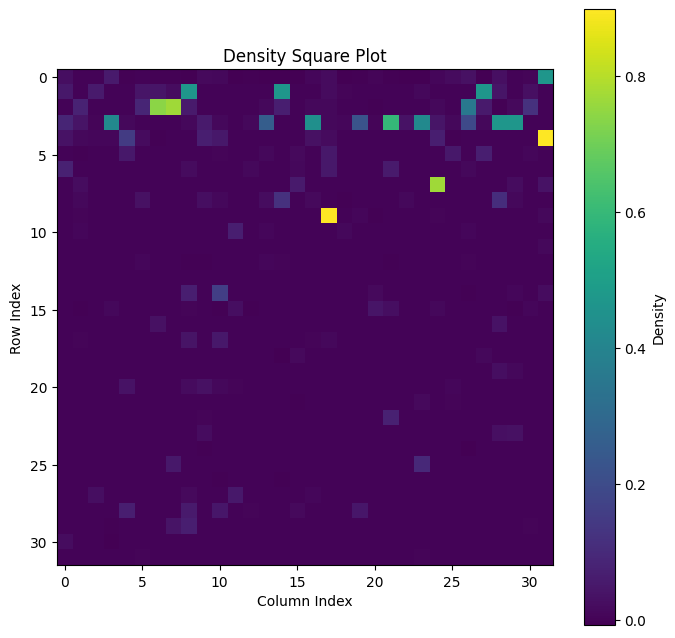

#### Plot Yes / No 

Silhouette Score: 0.5360187332518594 for layer 3 and head 9
Davies-Bouldin Score: 0.8236471520094455 for layer 3 and head 9
Silhouette Score: 0.63766156065787 for layer 13 and head 0
Davies-Bouldin Score: 0.7507643089946595 for layer 13 and head 0
Silhouette Score: 0.6115510955100777 for layer 13 and head 11
Davies-Bouldin Score: 0.9595070559205641 for layer 13 and head 11
Silhouette Score: 0.5076556183403023 for layer 14 and head 0
Davies-Bouldin Score: 1.1576620395732262 for layer 14 and head 0
Silhouette Score: 0.631456160293508 for layer 15 and head 5
Davies-Bouldin Score: 1.6437479817769312 for layer 15 and head 5
Silhouette Score: 0.8898196788134045 for layer 15 and head 7
Davies-Bouldin Score: 0.8587261396865691 for layer 15 and head 7


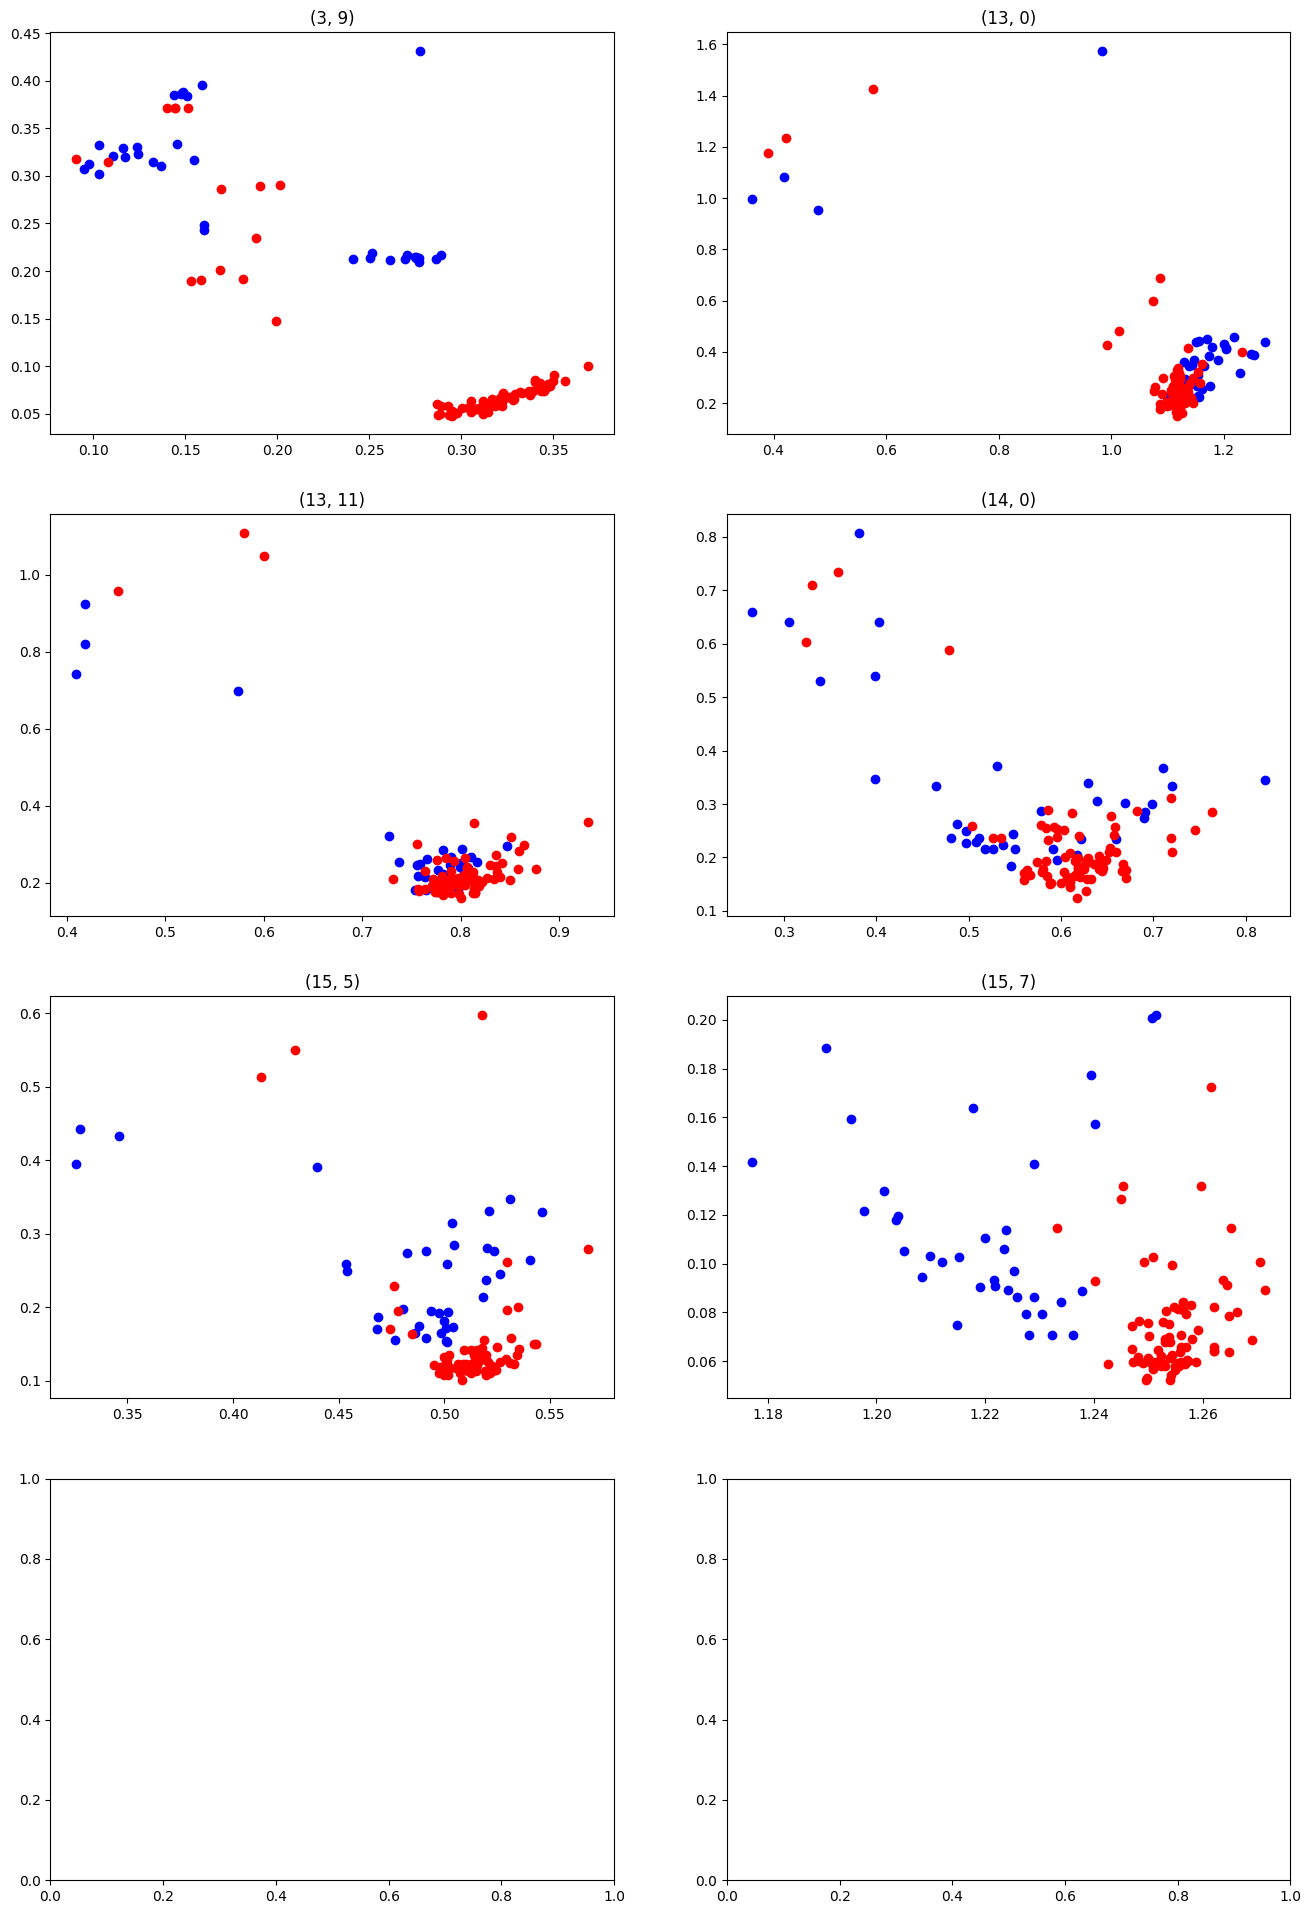

In [11]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
#heads = [(13,0), (13,11), (31,14), (30,0), (11,8), (8,24), (7,24), (10, 23), (17,23), (18,0)]
#heads = [(4,31), (15,2), (13,0), (10,23), (15,3),(3,6),(9,17), (13,19),(3,14), (7,14)]
#heads = [(2,7), (13,0), (13,11), (2,6)]
#heads = [(13, 0), (13, 8), (13, 11), (0, 31), (1, 0), (3, 9), (7, 24), (10, 23), (15, 2), (17, 23), (28, 8), (30, 0), (31, 13), (31, 14), (31, 28), (31, 30)]
heads = [(3,9), (13,0), (13,11),(14,0), (15,5), (15,7)]
n_rows = len(heads) // 2 + 1
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(16, 24))

for id, head in enumerate(heads):

    ax = fig.axes[id] 
    ax.set_title(str(head))

    layer = head[0]
    h = head[1]
    all_X_train = np.concatenate([separated_activations[i] for i in train_set_idxs], axis = 0)
    #print(all_X_train.shape)
    all_X_val = np.concatenate([separated_activations[i] for i in val_set_idxs], axis = 0)
    y_train = np.concatenate([separated_labels[i] for i in train_set_idxs], axis = 0)
    #print(y_train.shape)
    y_val = np.concatenate([separated_labels[i] for i in val_set_idxs], axis = 0)

    X_train = all_X_train[:,layer,h,:]
    X_train.shape

    X_val = all_X_val[:,layer,h,:]


    # Specify the number of clusters
    cl = KMeans(n_clusters=2, random_state=24, n_init="auto").fit(X_train)

    # The KMeans inertia attribute represents WCSS
    #wcss = cl.inertia_

    

    #print(f"Within-Cluster Sum of Squares (WCSS): {wcss} for layer {layer} and head {h}")

    # Here you add the silhouette score calculation
    # Calculate the silhouette score using the fit_predict method on X_train

    X_reduction = cl.transform(X_train)
    sil_score = silhouette_score(X_train, cl.labels_)
    db_score = davies_bouldin_score(X_train, cl.labels_)
    print(f"Silhouette Score: {sil_score} for layer {layer} and head {h}")
    print(f"Davies-Bouldin Score: {db_score} for layer {layer} and head {h}")
    X_val_reduction = cl.transform(X_val)

    for label, color in zip([True, False], ['blue', 'red']):

        #color = ['blue', 'red']
        #    ax.scatter(X_reduction[:,0], X_reduction[:,1], c=color[0])#, label=str(label))

        #ax.scatter(X_val_reduction[:,0], X_val_reduction[:,1], c=color[1])
        indexes_train = np.where(y_train == label)[0]
            ##indexes_val = np.where(y_val == 1)[0]
            #indexes = np.concatenate([indexes_train, indexes_val])

        for idx in indexes_train:
            #for i, idx in enumerate(df_reduced[indices_to_keep].index):
                #if idx in df_reduced[df_reduced['req_id'].isin(filt)].index :
                #ax.text(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], str(idx))
                            #print(idx)
                #if idx in df_reduced[true_false].index:
            if idx in [109, 5, 26]:
                continue
            ax.scatter(X_reduction[idx,0], X_reduction[idx, 1], c=color, label=str(idx))
            #ax.text(X_reduction[idx, 0], X_reduction[idx, 1], str(idx), size=5)

In [78]:
cl.labels_

array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1], dtype=int32)

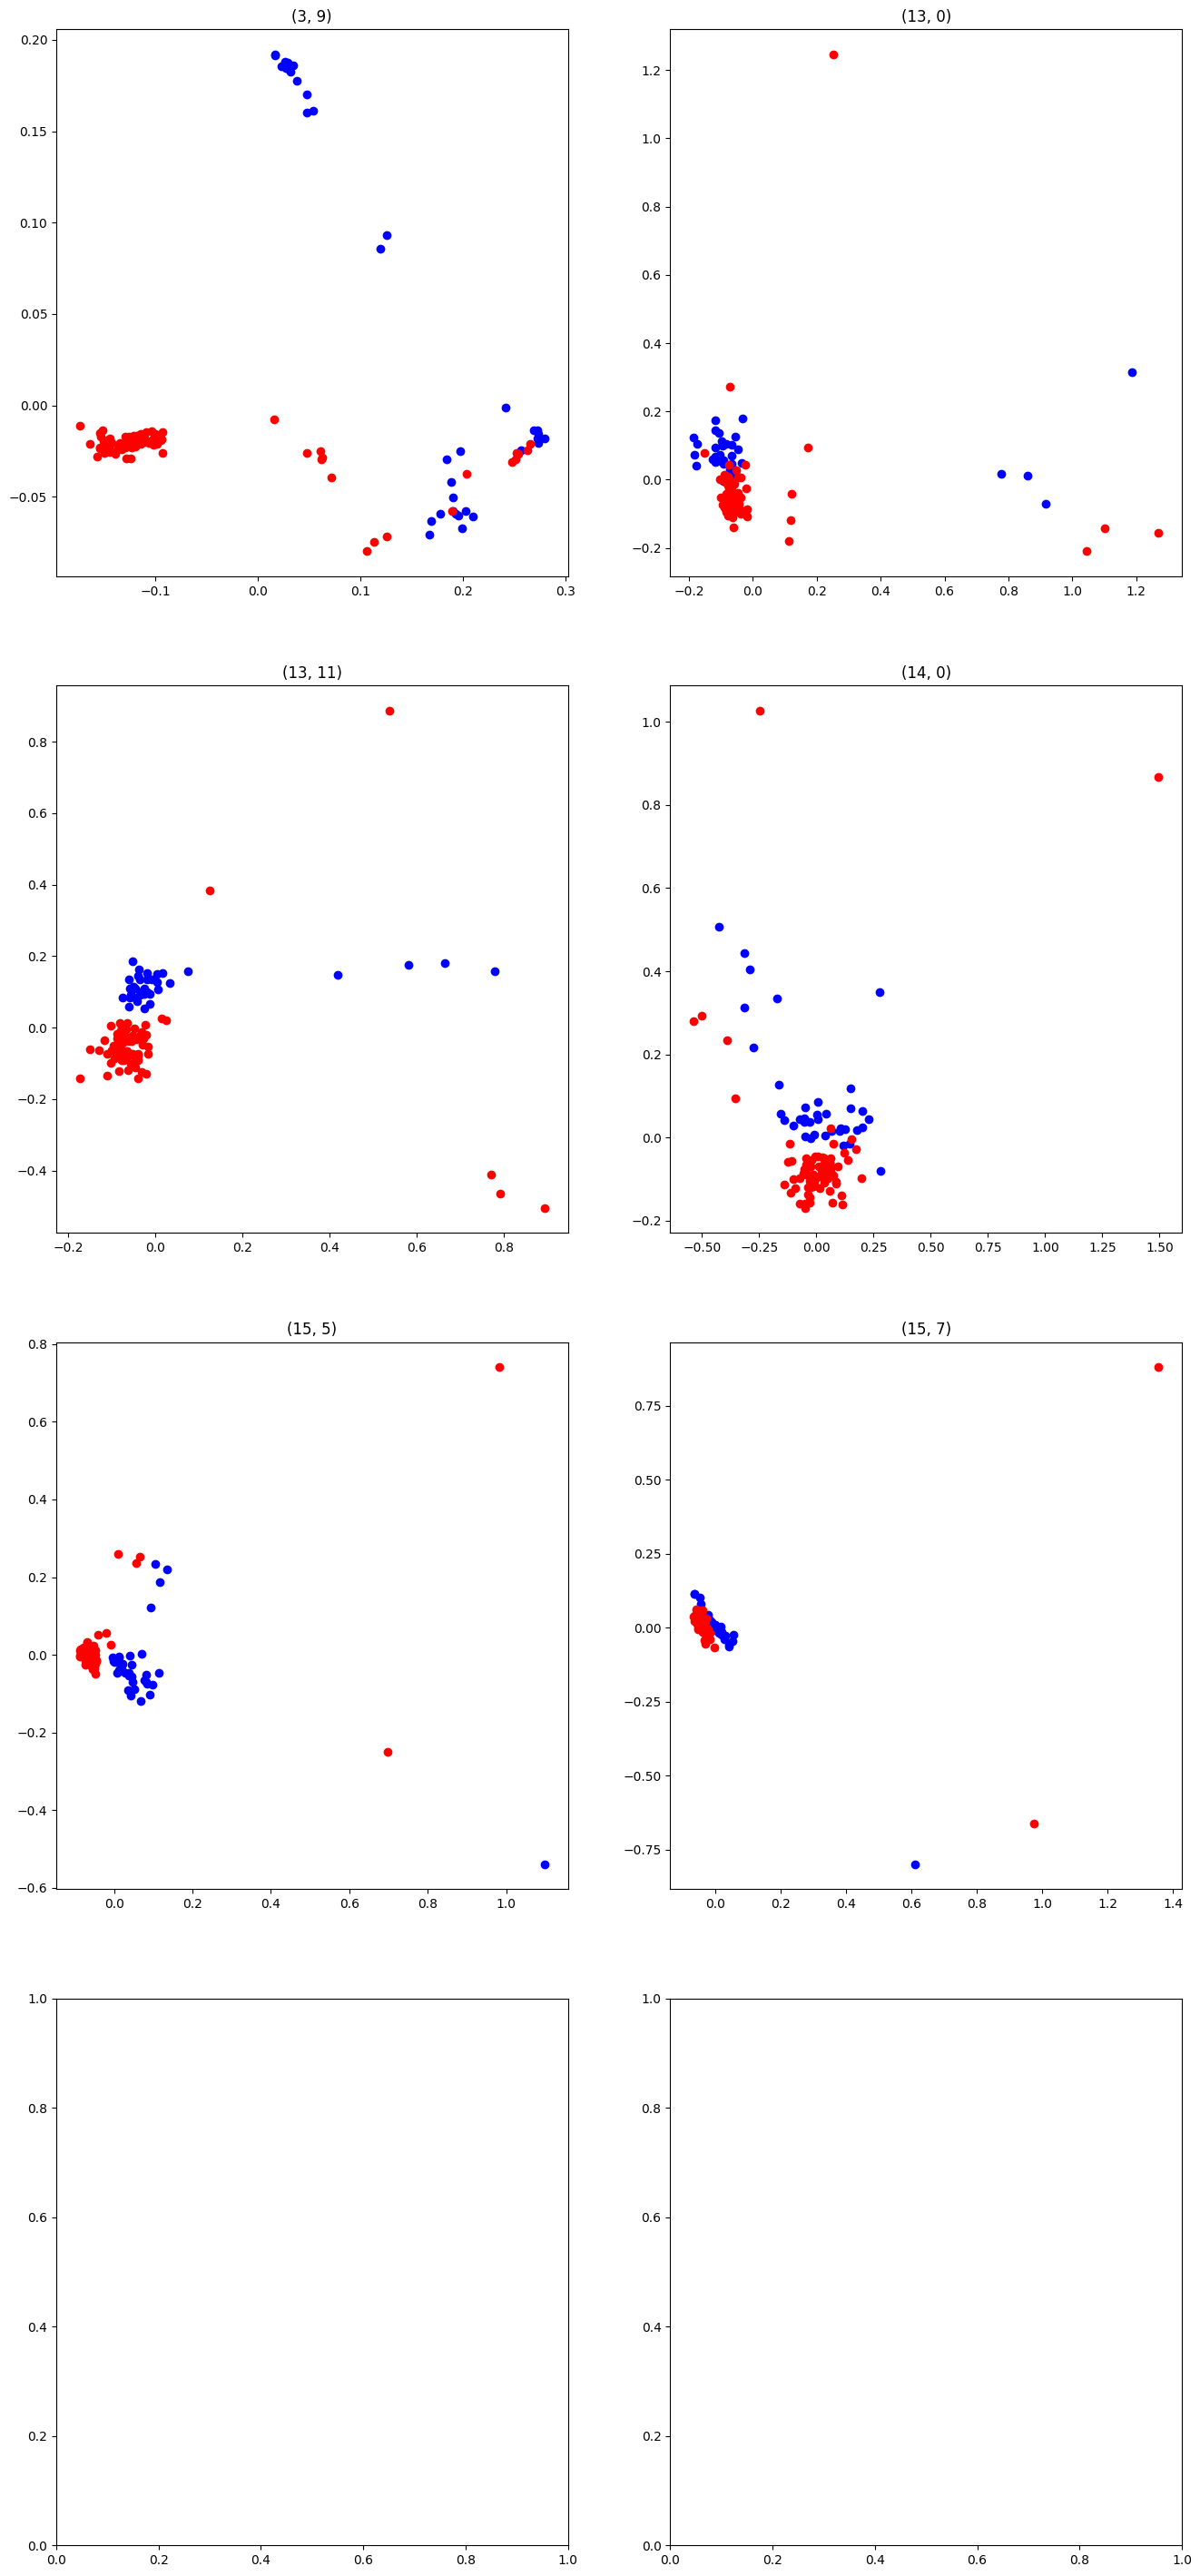

In [12]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np 
import matplotlib.pyplot as plt

heads = [(3,9), (13,0), (13,11),(14,0), (15,5), (15,7)]#,# (3,14)]#(11,8), (8,24), (7,24)]

#heads = [(13, 0), (13, 8), (13, 11), (0, 31), (1, 0), (3, 9), (7, 24), (10, 23), (15, 2), (17, 23), (28, 8), (30, 0), (31, 13), (31, 14), (31, 28), (31, 30)]
#heads = [(28, i) for i in range(0,32)]
#for head in heads:
## 14 0 14 10 15 5 15 6 15 7 16 6 17 20
n_rows = len(heads) // 2 + 1
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(16, 36))

for id, head in enumerate(heads):

    ax = fig.axes[id] 
    ax.set_title(str(head))
    layer = head[0]
    h = head[1]
    all_X_train = np.concatenate([separated_activations[i] for i in train_set_idxs], axis = 0)
    #print(all_X_train.shape)
    all_X_val = np.concatenate([separated_activations[i] for i in val_set_idxs], axis = 0)
    y_train = np.concatenate([separated_labels[i] for i in train_set_idxs], axis = 0)
    #print(y_train.shape)
    y_val = np.concatenate([separated_labels[i] for i in val_set_idxs], axis = 0)

    X_train = all_X_train[:,layer,h,:]
    X_train.shape

    X_val = all_X_val[:,layer,h,:]
    X_val.shape

    #cl = TSNE(n_components=2, random_state=args.seed).fit(X_train)
    cl = PCA(n_components=2, random_state=args.seed).fit(X_train)
    X_reduction = cl.transform(X_train)
    X_val_reduction = cl.transform(X_val)

    for label, color in zip([True, False], ['blue', 'red']):

        #color = ['blue', 'red']
        #    ax.scatter(X_reduction[:,0], X_reduction[:,1], c=color[0])#, label=str(label))

        #ax.scatter(X_val_reduction[:,0], X_val_reduction[:,1], c=color[1])
        indexes_train = np.where(y_train == label)[0]
            ##indexes_val = np.where(y_val == 1)[0]
            #indexes = np.concatenate([indexes_train, indexes_val])

        for idx in indexes_train:
            #for i, idx in enumerate(df_reduced[indices_to_keep].index):
                #if idx in df_reduced[df_reduced['req_id'].isin(filt)].index :
                #ax.text(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], str(idx))
                            #print(idx)
                #if idx in df_reduced[true_false].index:
            
            ax.scatter(X_reduction[idx,0], X_reduction[idx, 1], c=color, label=str(idx))
            #ax.scatter(X_reduction[idx,0], 1, c=color, label=str(idx))
            #ax.hist(X_reduction[idx,0], bins=35, color=color, alpha=0.4, label=str(idx))  # Histogram
                     

In [20]:
print(indexes)

[ 17  18  19  20  23  24  25  26  27  28  29  31  32  33  34  37  40  41
  42  46  47  48  49  50  51  58  59  60  61  62  69  70  71  72  73  74
  81  82  83  85  86  89  99 100 101 102 103 104 111 113 114 116 117 118
 119 124 145 149 151 153 154 157 158 159 160 161 164 165 166 167 168 169
 170 171 172 173 174 176   1   6  11  13  18  19  20  21  25  27  28  36
  37  38  39]


### Class Variance ratios

In [15]:
ratios = []
separated_head_wise_activations = separated_activations

all_X_train = np.concatenate([separated_head_wise_activations[i] for i in train_set_idxs], axis = 0)
print(all_X_train.shape)
all_X_val = np.concatenate([separated_head_wise_activations[i] for i in val_set_idxs], axis = 0)
y_train = np.concatenate([separated_labels[i] for i in train_set_idxs], axis = 0)
print(y_train.shape)
y_val = np.concatenate([separated_labels[i] for i in val_set_idxs], axis = 0)

for layer in tqdm(range(num_layers)): 
        for h in range(num_heads): 
                
                label =1
                indexes_yes = np.where(y_train == label)[0]
                ##indexes_val = np.where(y_val == 1)[0]
                #indexes = np.concatenate([indexes_train, indexes_val])

                
                ## needs to be split
                set1 = all_X_train[indexes_yes,layer,h,:]
                
                label =0
                indexes_no = np.where(y_train == label)[0]
                set2 = all_X_train[indexes_no,layer,h,:]

                # Assuming set1 and set2 are your two classes of data
                mean1 = np.mean(set1, axis=0)
                mean2 = np.mean(set2, axis=0)

                # Between-class variance (squared difference between class means)
                between_class_variance = np.sum((mean1 - mean2) ** 2)

                # Within-class variances (average variance within each class)
                within_class_variance = (np.var(set1, axis=0).mean() + np.var(set2, axis=0).mean()) / 2

                # Ratio similar to Fisher's criterion but without projection
                ratio = between_class_variance / within_class_variance

                ratios.append(ratio)

ratios = np.array(ratios)

In [ ]:
from matplotlib.patches import Rectangle
from matplotlib import pyplot as plt
#data = np.random.rand(10,10) # Example data

data = ratios.reshape(32,32) # np.random.rand(32, 32)  # Example data

fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.imshow(data, cmap='viridis', interpolation='nearest')

heads = [(13, 0), (13, 11), (14, 0), (15, 5), (15, 7)]


#x, y = 5, 5  # for example, highlighting the field at (5, 5)
for head in heads: 
    # Coordinates of the field you want to highlight
    # Note: Matplotlib's coordinate system starts from the top left corner as (0, 0)
    x = head[1]
    y = head[0]
    print(data[head[0], head[1]])
    # Create a rectangle outline
    # Arguments: (x, y) - lower left corner, width, height, edgecolor, and fill
    rect = Rectangle((x-0.5, y-0.5), 1, 1, linewidth=2, edgecolor='r', facecolor='none')

    # Add the rectangle to the Axes
    ax.add_patch(rect)

# Add a colorbar associated with the Axes object's content
fig.colorbar(cax, ax=ax, label='Density')

# Set titles and labels
ax.set_title('Prediction accuracy for Yes/No answers')
ax.set_xlabel('Head Index')
ax.set_ylabel('Layer Index')

plt.show()


#### 1d plotting

In [ ]:
# Plot separability 
data = {}
heads = [(13,0), (13,11), (31,14), (30,0)]
for head in heads: 

    layer = head[0]
    h = head[1]
    all_X_train = np.concatenate([separated_activations[i] for i in train_set_idxs], axis = 0)
    print(all_X_train.shape)
    all_X_val = np.concatenate([separated_activations[i] for i in val_set_idxs], axis = 0)
    y_train = np.concatenate([separated_labels[i] for i in train_set_idxs], axis = 0)
    print(y_train.shape)
    y_val = np.concatenate([separated_labels[i] for i in val_set_idxs], axis = 0)

    coefficients = probes[layer_head_to_flattened_idx(layer, h, num_heads)].coef_

    print(coefficients.shape)

    X_train = all_X_train[:,layer,h,:]
    X_train.shape

    X_val = all_X_val[:,layer,h,:]
    X_val.shape

    #logits = coefficients.dot(X_train.T)
    logits = coefficients @ X_val.T
    #logits.shape

    #data[str(layer)+"_"+ str(h)]= logits.squeeze()
    data[str(head)]= logits.squeeze()
    #print(logits)
data['labels']= y_val
data = pd.DataFrame(data)

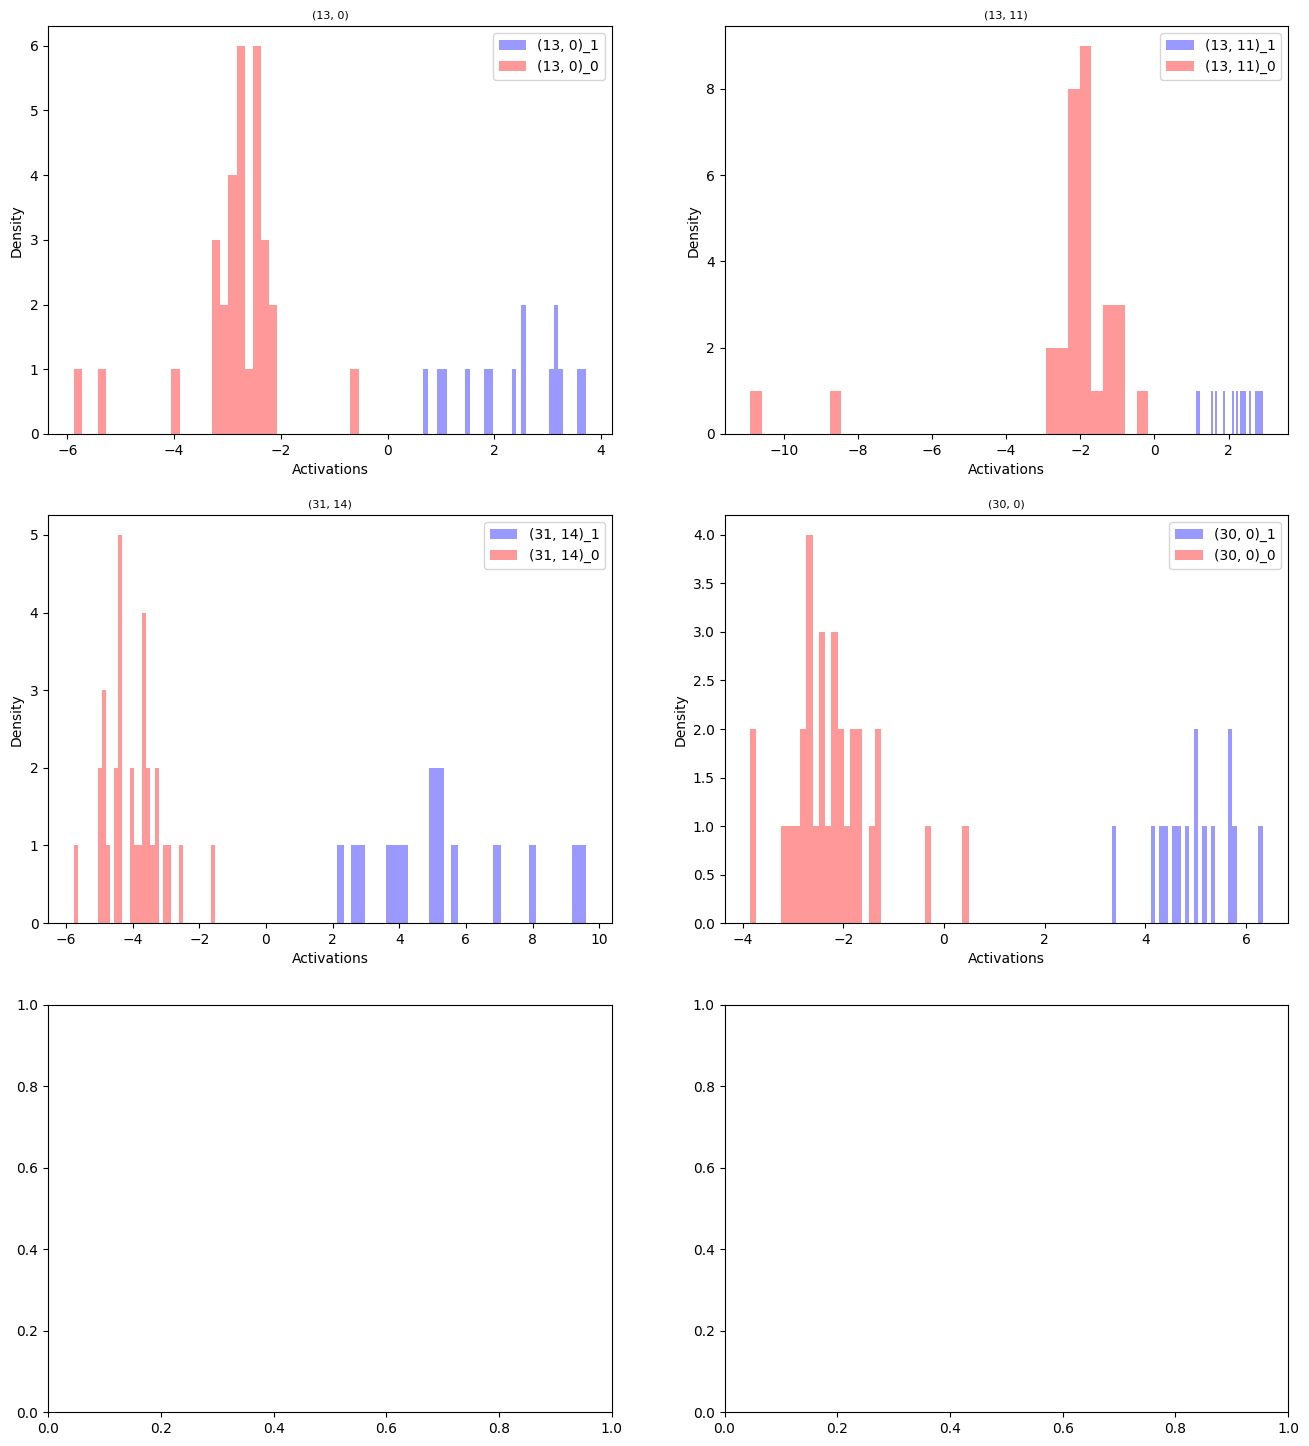

In [161]:
import matplotlib.pyplot as plt
def plot_1d_data(data, columns):
       
       n_rows = len(columns) // 2 +1
       fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(16, 18))

       for id, column in enumerate(columns):

              ax = fig.axes[id] 
              # Plotting
              for label, color in zip([1, 0], ['blue', 'red']):
                     
                     points = data[data['labels']== label][column].dropna()  # Remove NaN values
                     ax.hist(points, bins=35, color=color, alpha=0.4, label=f"{column}_{label}")  # Histogram
                     #density = gaussian_kde(data)
                     #xs = np.linspace(min(data), max(data), 200)  # 200 points between min and max
                     #ax.plot(xs, density(xs), label=column+"_"+str(label), c=color)
                     ax.legend(prop={'size': 10})
                     ax.set_title(column, size=8)
                     ax.set_xlabel('Activations')
                     ax.set_ylabel('Density')
                     ax.legend(prop={'size': 10})

       plt.show()
columns = [str(i) for i in heads]
plot_1d_data(data, columns)



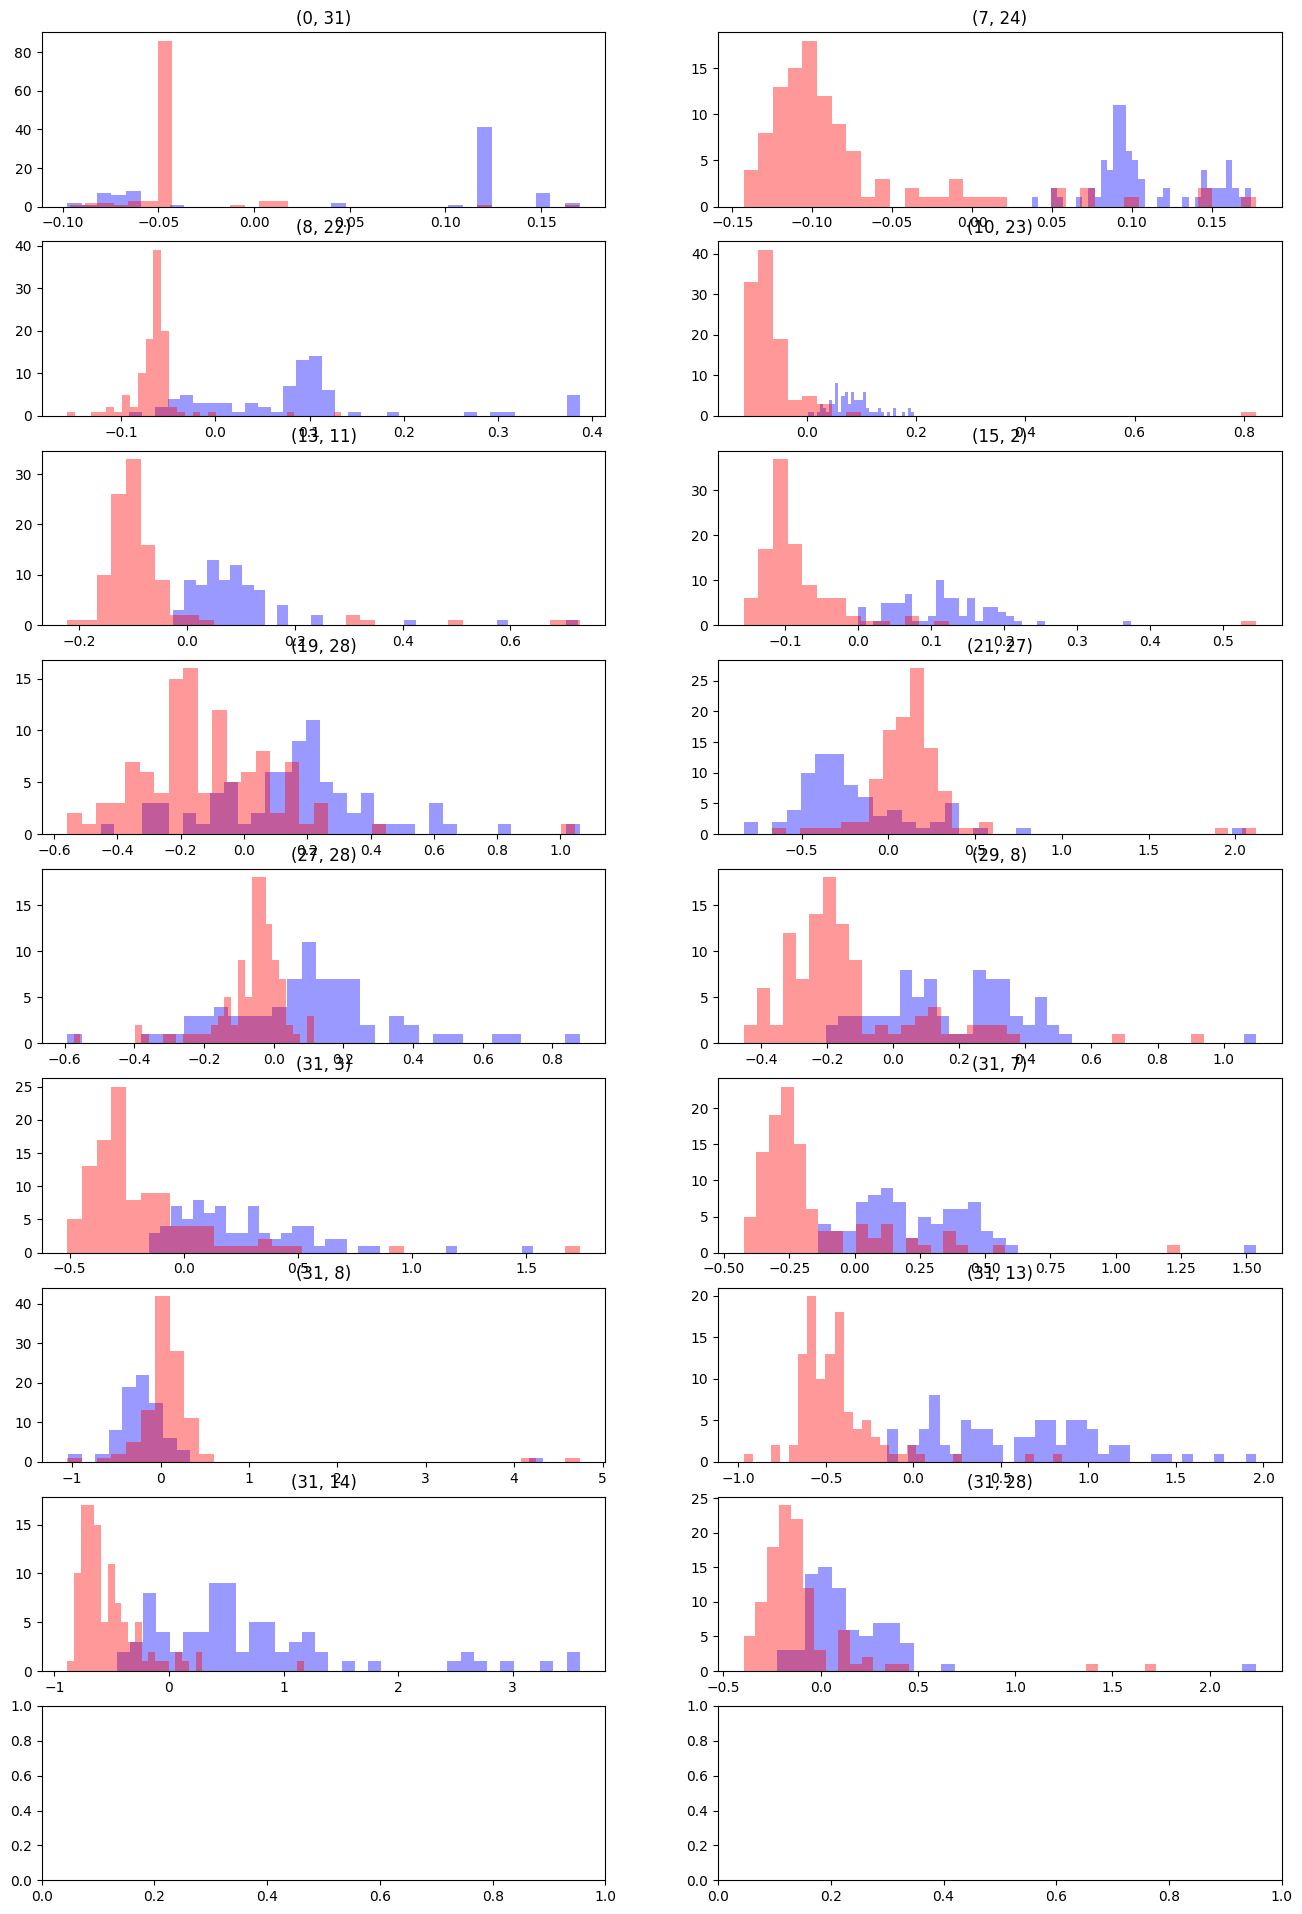

In [35]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np 
import matplotlib.pyplot as plt

#heads = [(13,0), (13,11), (31,14), (30,0), (11,8), (8,24)]

#heads = [(13, 0), (13, 8), (13, 11), (0, 31), (1, 0), (3, 9), (7, 24), (10, 23), (15, 2), (17, 23), (28, 8), (30, 0), (31, 13), (31, 14), (31, 28), (31, 30)]
heads = [(0, 31), (7, 24), (8, 22), (10, 23), (13, 11), (15, 2), (19, 28), (21, 27), (27, 28), (29, 8), (31, 3), (31, 7), (31, 8), (31, 13), (31, 14), (31, 28)]
#for head in heads:

n_rows = len(heads) // 2 + 1
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(16, 24))

for id, head in enumerate(heads):

    ax = fig.axes[id] 
    ax.set_title(str(head))
    layer = head[0]
    h = head[1]
    all_X_train = np.concatenate([separated_activations[i] for i in train_set_idxs], axis = 0)
    #print(all_X_train.shape)
    all_X_val = np.concatenate([separated_activations[i] for i in val_set_idxs], axis = 0)
    y_train = np.concatenate([separated_labels[i] for i in train_set_idxs], axis = 0)
    #print(y_train.shape)
    y_val = np.concatenate([separated_labels[i] for i in val_set_idxs], axis = 0)

    X_train = all_X_train[:,layer,h,:]
    X_train.shape

    X_val = all_X_val[:,layer,h,:]
    X_val.shape

    #cl = TSNE(n_components=2, random_state=args.seed).fit(X_train)
    cl = PCA(n_components=1, random_state=args.seed).fit(X_train)
    X_reduction = cl.transform(X_train)
    X_val_reduction = cl.transform(X_val)

    for label, color in zip([True, False], ['blue', 'red']):


        #color = ['blue', 'red']
        #    ax.scatter(X_reduction[:,0], X_reduction[:,1], c=color[0])#, label=str(label))

        #ax.scatter(X_val_reduction[:,0], X_val_reduction[:,1], c=color[1])
        indexes_train = np.where(y_train == label)[0]
            ##indexes_val = np.where(y_val == 1)[0]
            #indexes = np.concatenate([indexes_train, indexes_val])

        examples = [X_reduction[idx] for idx in indexes_train]
        examples = np.array(examples).squeeze()
            #for i, idx in enumerate(df_reduced[indices_to_keep].index):
                #if idx in df_reduced[df_reduced['req_id'].isin(filt)].index :
                #ax.text(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], str(idx))
                            #print(idx)
                #if idx in df_reduced[true_false].index:
            
        ax.hist(examples, bins=35, color=color, alpha=0.4, label=str(idx))  # Histogram
                     

array([-5.16439423e-02, -8.06989063e-02, -1.24755373e-01, -2.11583131e-02,
       -1.76381255e-01,  9.45378358e-02, -2.02032862e-03, -9.60798327e-02,
       -5.82633992e-02,  3.18663549e-01, -7.40104490e-02, -2.42915730e-02,
       -1.15869293e-01, -1.16433619e-01, -1.61033524e-01, -1.18583117e-01,
       -1.56974241e-02, -1.79615276e-01, -2.14310657e-01, -1.27130487e-01,
       -1.95461047e-01, -1.25442062e-01, -6.92630805e-02, -4.92400741e-02,
        2.24658726e-01, -2.79322102e-02,  1.83735108e+00, -2.84534439e-02,
       -1.00435181e-01, -1.91817098e-01, -1.78168873e-01, -2.70222537e-01,
       -1.71600172e-01, -2.92167168e-01, -1.47303699e-01, -1.02528570e-01,
       -1.22346315e-01, -1.01513452e-01, -4.59751306e-02, -2.01464117e-01,
       -2.93932195e-01, -2.68015728e-01, -1.90685982e-01, -8.14834253e-02,
       -2.95857227e-01, -1.00827239e-01,  1.58017775e-03, -8.01224919e-02,
        2.54713712e-02, -7.99145935e-02, -7.47345004e-02, -1.66137489e-01,
       -1.38845109e-01,  

In [14]:
# heads = [(13, 0,), (13,11), (11, 17), (30, 2), (30, 9), (30, 16), (31, 4), (31, 5), (31, 7), (31, 13), (31, 14), (31, 20), (31, 22), (31, 28)]
# for head in heads: 
#     print(head)
#     layer = head[0]
#     head = head[1]
#     all_X_train = np.concatenate([separated_activations[i] for i in train_set_idxs], axis = 0)

#     head_actis = all_X_train[:,layer,head,:]
#     actis_std = np.std(head_actis, axis = 0)
#     #print(actis_std.shape)
#     print(actis_std.max())
#     print(actis_std.min())
#     print(actis_std.max() - actis_std.min())
#     #head_actis.shape
#     euclidean_norm = np.linalg.norm(head_actis, axis=1)
#     sum_norm = np.sum(euclidean_norm)
    
    #print(sum_norm)

### manual checking of right or wrong

In [140]:
# layer = 31
# head = 14

layer = 13
head = 0 
separated_head_wise_activations = separated_activations

train_set_idxs = np.array([39, 31, 24, 15, 26, 28, 21, 33, 25, 30, 38, 18, 16])
val_set_idxs = np.array([14, 17, 19, 20, 22, 23, 27, 29, 32, 34, 35, 36, 37])

all_X_train = np.concatenate([separated_head_wise_activations[i] for i in train_set_idxs], axis = 0)
print(all_X_train.shape)
X_train = all_X_train[:,layer,head,:]
X_val = all_X_val[:,layer,head,:]

all_X_val = np.concatenate([separated_head_wise_activations[i] for i in val_set_idxs], axis = 0)
y_train = np.concatenate([separated_labels[i] for i in train_set_idxs], axis = 0)
print(y_train.shape)
y_val = np.concatenate([separated_labels[i] for i in val_set_idxs], axis = 0)

dim_reduction = PCA(n_components = 2).fit(X_train)
X_val_transform = dim_reduction.transform(X_val)
# X_train = all_X_train[:,layer,head,:]

# dim_reduction = PCA(n_components = 2).fit(X_train)
# X_train_transform = dim_reduction.transform(X_train)

X_val = X_val_transform
# val_set_idxs = np.array([14, 17, 19, 20, 22, 23, 27, 29, 32, 34, 35, 36, 37])
clf = fold_probes[0][layer_head_to_flattened_idx(layer, head, num_heads)]
y_pred = clf.predict(X_val)

(75, 32, 32, 128)
(75,)


In [142]:
# Lengths for each split
lengths = y_val_len

# Splitting the array
splits = []
start = 0
for length in lengths:
    end = start + length
    split = y_pred[start:end]
    splits.append(split)
    start = end
splits

[array([1, 0, 0, 1, 1]),
 array([1, 1, 1, 1, 0, 0]),
 array([1, 1, 0, 0, 0, 1]),
 array([1, 1, 1, 1, 0]),
 array([0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0]),
 array([1, 0, 0, 1, 0, 0]),
 array([0, 0, 0, 0, 0, 0]),
 array([1, 0, 1, 1, 1, 0]),
 array([1, 1, 1, 1, 1]),
 array([0, 0, 0, 1, 1, 0]),
 array([1, 1, 1, 0, 1]),
 array([0, 0, 0, 0, 0, 1])]

In [130]:
y_val = [separated_labels[i] for i in val_set_idxs]
y_val_len = [len(i) for i in y_val]
y_val

[[1, 0, 1, 1, 1],
 [1, 1, 1, 0, 0, 0],
 [1, 1, 1, 0, 1, 1],
 [1, 0, 1, 1, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [1, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 0],
 [1, 1, 1, 1, 1],
 [0, 0, 0, 1, 0, 0],
 [0, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0]]

In [97]:
y_val[7]

1

In [1]:
# label_id = 0
# index = val_set_idxs[label_id]
# print("Predict: ", splits[label_id])
# print(index)
# req_id = reqs_order[index]
# print(req_id)
# print(separated_labels[index])

# print(df[df.req_id == req_id].final_answer.values)
# for out in df[df.req_id == req_id].output:

#     print("__________________")
#     print(out)

In [98]:
[separated_labels[i] for i in val_set_idxs][0:2]

[[1, 0, 1, 1, 1], [1, 1, 1, 0, 0, 0]]

In [90]:
#fold_probes.append(probes)
#fold_results.append(all_head_accs_np)

#fold_probes[0][layer_head_to_flattened_idx(31, 14, num_heads)]

In [80]:
fold_results[0][layer_head_to_flattened_idx(31, 14, num_heads)]

0.9459459459459459

### Plotting of accuracies

Text(0, 0.5, 'Row Index')

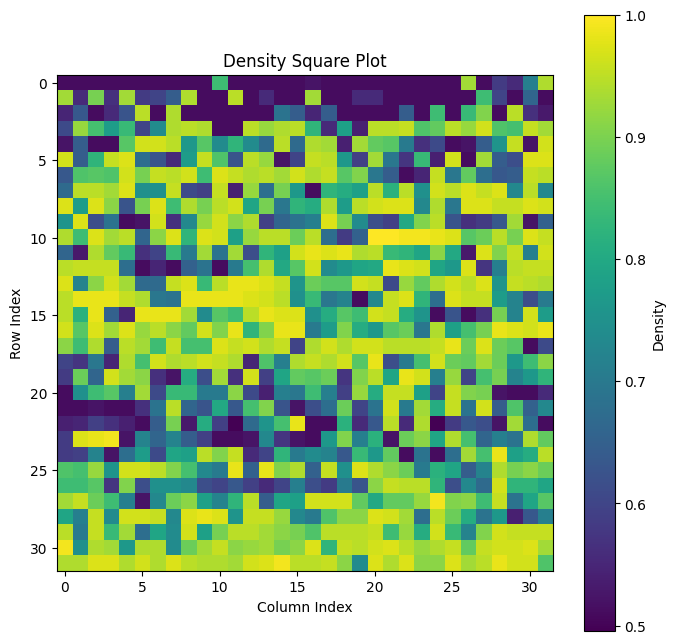

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the average accuracy across all folds
average_accuracy = np.mean(fold_results, axis=0)
#average_accuracy.shape

# Assuming 'data' is your 32x32 dataset
# Replace this with your actual data matrix
#data = all_head_accs_np.reshape(32,32) # np.random.rand(32, 32)  # Example data
data = fold_results[0].reshape(32,32) # np.random.rand(32, 32)  # Example data
#data = average_accuracy.reshape(32,32) # np.random.rand(32,32) 

plt.figure(figsize=(8, 8))
plt.imshow(data, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Density')

plt.title('Density Square Plot')
plt.xlabel('Column Index')
plt.ylabel('Row Index')


Text(0, 0.5, 'Row Index')

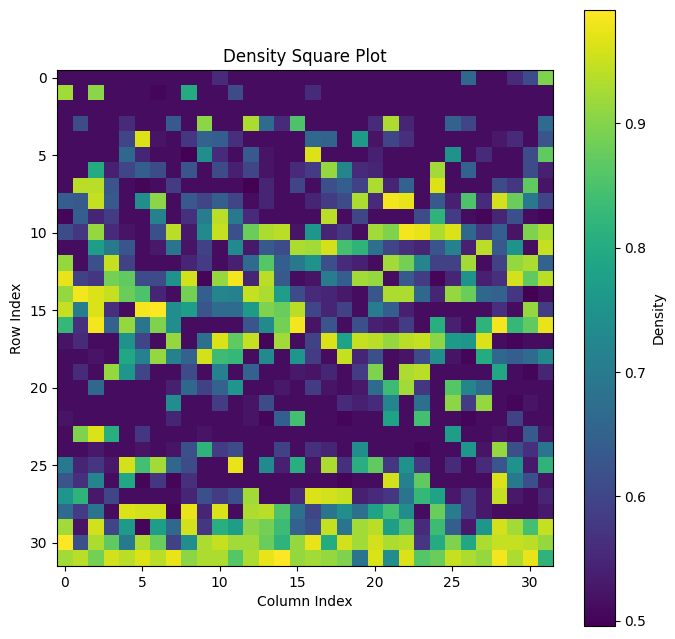

In [130]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the average accuracy across all folds
average_accuracy = np.mean(fold_results, axis=0)
#average_accuracy.shape

# Assuming 'data' is your 32x32 dataset
# Replace this with your actual data matrix
#data = all_head_accs_np.reshape(32,32) # np.random.rand(32, 32)  # Example data
data = fold_results[0].reshape(32,32) # np.random.rand(32, 32)  # Example data
#data = average_accuracy.reshape(32,32) # np.random.rand(32,32) 

plt.figure(figsize=(8, 8))
plt.imshow(data, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Density')

plt.title('Density Square Plot')
plt.xlabel('Column Index')
plt.ylabel('Row Index')


Text(0, 0.5, 'Row Index')

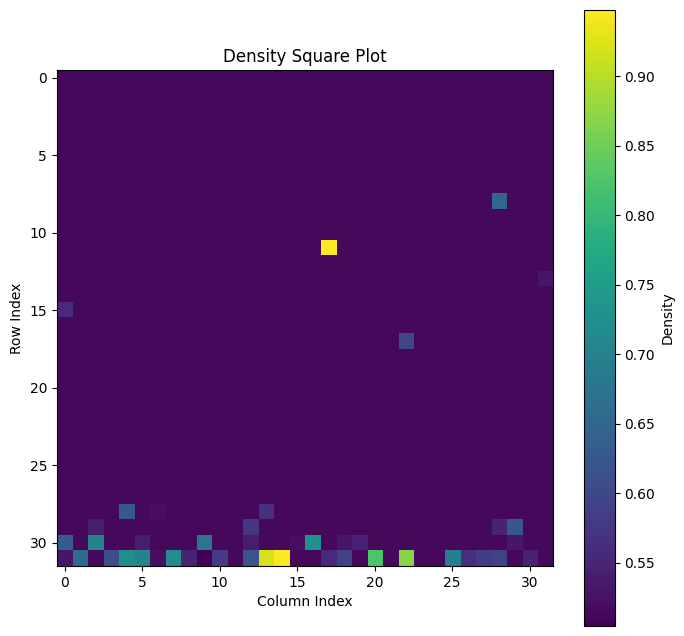

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'data' is your 32x32 dataset
# Replace this with your actual data matrix
data = all_head_accs_np.reshape(32,32) # np.random.rand(32, 32)  # Example data

plt.figure(figsize=(8, 8))
plt.imshow(data, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Density')

plt.title('Density Square Plot')
plt.xlabel('Column Index')
plt.ylabel('Row Index')


In [178]:
## no regularization
embedding_1 = np.array([-0.58706139,  0.65242486,  0.16431561,  0.28923372,  0.33296527,
        -0.43547102,  0.41890997,  0.92402343, -0.06827023, -0.13783952,
         0.14818   ,  0.27934029,  0.52922582,  0.21371336,  0.48967387,
         0.04276797,  0.13238384, -0.10438781, -0.78089802,  1.28364587,
        -0.44618538,  0.55607966,  0.04725375,  0.77209443,  0.06852715,
         0.83824029, -0.65030424, -0.04862489,  0.18961681,  0.26885525,
         0.0249526 ,  0.20691101,  0.00692141,  0.01643663,  0.04666864,
        -0.20990969, -0.22790568, -0.34784112,  0.25042659,  0.07382097,
         0.2391744 , -0.11740366, -0.31432133, -0.41217522,  0.32571527,
        -0.48647524, -0.03633225, -0.08645885,  0.86892886, -0.19038446,
         0.2948523 ,  0.17963875, -0.38163807, -0.43758306, -0.05774341,
        -0.3644051 , -0.59946709, -0.20491478,  0.64002582,  0.21520652,
        -0.57981274, -0.39775867, -0.13433292, -0.34548118, -0.34660692,
         0.51781075, -0.41619833, -0.04473495, -0.07308562,  0.35875712,
         0.12386732,  0.41799664,  0.27427482,  0.21051466,  0.80718428,
        -0.23616741,  0.76288499,  0.04844366,  0.15162442, -0.10546304,
         0.09308688, -0.21610534, -0.23683788, -0.48668593,  0.27359488,
        -0.04682159, -0.35969308, -0.44646548, -0.018485  , -0.13856888,
         0.25538014,  0.22054936, -0.08228309,  0.26221848, -0.00919723,
         0.24780873,  0.36478159, -0.01148897, -0.09497173, -0.29346626,
         0.09621763, -0.16013562, -0.04560661, -0.4912527 ,  0.00679573,
         0.34772916, -0.45220737, -0.08448583, -0.07549173,  0.08215138,
        -0.1753249 ,  0.00574164, -0.42194947, -0.06116365, -0.25526465,
         0.59100451, -0.16606719, -0.5516485 ,  0.09569886, -0.13037198,
         0.11499235, -0.22096293, -0.57105139,  0.7965566 ,  0.14996739,
        -0.77648496,  0.15904055,  0.31063182])
## strong regularization (C = 0.5)
embedding_2 = np.array([-6.08339780e-01,  4.82057839e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         9.39038228e-04,  9.45396720e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         6.80825823e-01,  0.00000000e+00,  1.43136003e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -5.42778060e-01,  1.54585299e+00,  0.00000000e+00,
         5.47544241e-02,  0.00000000e+00,  8.18043335e-01,
         0.00000000e+00,  7.08792820e-01, -3.34661746e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.83357093e-01,  0.00000000e+00,  0.00000000e+00,
         1.10228536e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -2.00044033e-01,
        -6.56769644e-02,  2.71845793e-01,  0.00000000e+00,
        -4.48647517e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.97545425e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  8.77203403e-01,
         0.00000000e+00,  4.18652669e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.31578285e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -3.11888933e-01,  0.00000000e+00,
         0.00000000e+00, -2.32653547e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  2.69725625e-01,  0.00000000e+00,
        -3.10019694e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -4.22999638e-01,
         9.06506484e-01,  0.00000000e+00, -5.88661460e-01,
         0.00000000e+00,  0.00000000e+00])

## low tolerance e10-5
embedding_3 = probes[layer_head_to_flattened_idx(31, 14, num_heads)].coef_.squeeze()

from sentence_transformers import util
embeds = np.stack([embedding_1, embedding_2, embedding_3])
util.cos_sim(embeds, embeds)

tensor([[1.0000, 0.7763, 0.6821],
        [0.7763, 1.0000, 0.4367],
        [0.6821, 0.4367, 1.0000]], dtype=torch.float64)

In [34]:
args = Args(val_ratio=0.5, use_center_of_mass=False, use_random_dir=False, seed=42, num_heads=16)      

top_heads, probes = get_top_heads(train_set_idxs, val_set_idxs, separated_activations, separated_labels, num_layers, num_heads, args.seed, args.num_heads, args.use_random_dir)
 
print("Heads intervened: ", sorted(top_heads))

tuning_activations = separated_activations
tuning_activations = np.concatenate(tuning_activations, axis = 0)
#tuning
#print(tuning_activations.shape)
#print(len(tuning_activations))
#print(tuning_activations.shape)

com_directions = None
interventions = get_interventions_dict(top_heads, probes, tuning_activations, num_heads, args.use_center_of_mass, args.use_random_dir, com_directions)


(185, 32, 32, 128)
(185,)


  0%|          | 0/32 [00:00<?, ?it/s]

[1005  248  482 1006   31 1000  699  278  999  936  427  636  892  995
 1020  343]
Heads intervened:  [(0, 31), (7, 24), (8, 22), (10, 23), (13, 11), (15, 2), (19, 28), (21, 27), (27, 28), (29, 8), (31, 3), (31, 7), (31, 8), (31, 13), (31, 14), (31, 28)]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 128)

The average correlation between input features is: 0      0.071250
1      0.038152
2     -0.004344
3     -0.053032
4      0.019530
         ...   
123    0.042715
124   -0.040775
125    0.019692
126    0.089754
127    0.041494
Length: 128, dtype: float64


In [79]:
data_snippet = corr_matrix[(corr_matrix > 0.6) | (corr_matrix < -0.6)].notna()

# Convert the data snippet into a flat list containing all the True/False values.

flat_list = [item for row in data_snippet.iterrows() for item in row[1]]

# Count the number of True values in the flat list.

true_count = flat_list.count(True)

true_count

718

In [10]:
top_heads, probes = get_top_heads(train_set_idxs, val_set_idxs, separated_activations, separated_labels, num_layers, num_heads, args.seed, args.num_heads, args.use_random_dir)
        
print("Heads intervened: ", sorted(top_heads))

tuning_activations = separated_activations
tuning_activations = np.concatenate(tuning_activations, axis = 0)
#tuning
#print(tuning_activations.shape)
#print(len(tuning_activations))
#print(tuning_activations.shape)

com_directions = None
interventions = get_interventions_dict(top_heads, probes, tuning_activations, num_heads, args.use_center_of_mass, args.use_random_dir, com_directions)


(116, 32, 32, 128)
(116,)


  0%|          | 0/32 [00:00<?, ?it/s]

[ 486  960 1006  485  427  540  514  342  277  449  527 1020]
Heads intervened:  [(8, 21), (10, 22), (13, 11), (14, 1), (15, 5), (15, 6), (16, 2), (16, 15), (16, 28), (30, 0), (31, 14), (31, 28)]


In [11]:
print("Heads intervened: ", sorted(top_heads))

Heads intervened:  [(8, 21), (10, 22), (13, 11), (14, 1), (15, 5), (15, 6), (16, 2), (16, 15), (16, 28), (30, 0), (31, 14), (31, 28)]


In [28]:
#sorted(top_heads)

In [193]:
# Convert each tuple into a bash array element
bash_array_elements = ['"{} {}"'.format(t[0], t[1]) for t in top_heads]

# Join elements to get the bash array definition
bash_array = " ".join(bash_array_elements)

print("K_pairs=(" + bash_array + ")")


K_pairs=("22 15" "24 27" "3 3" "26 30" "3 10" "10 9" "3 14" "10 8")


In [12]:
all_head_accs_np[layer_head_to_flattened_idx(13, 0, num_heads)]

0.9739130434782609

In [27]:
# sorted = np.sort(all_head_accs_np)[::-1]
# sorted[0:128]

### Multicolinearity 

In [ ]:
import pandas as pd
import numpy as np

layer = 13
head = 0 
activations = tuning_activations[:,layer,head,:] # batch x 128

corr_df = pd.DataFrame(activations)

# Assuming df is your dataframe with input features
corr_matrix = corr_df.corr()

# Mask to exclude the diagonal elements
mask = np.ones(corr_matrix.shape, dtype=bool)
np.fill_diagonal(mask, 0)

# Calculate the average correlation
avg_corr = corr_matrix[mask].mean()

print(f"The average correlation between input features is: {avg_corr}")

In [64]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

layer = 8
head = 22
tuning_activations = separated_activations
tuning_activations = np.concatenate(tuning_activations, axis = 0)
#activations = tuning_activations[:,layer:layer+2,head,:] # batch x 128
activations = tuning_activations[:,layer,head,:128] # batch x 128

# Assuming 'features' is your DataFrame containing all the predictor variables
# It should not include the target variable
features = pd.DataFrame(activations)

# Add a constant to the features for the intercept
features_with_constant = sm.add_constant(features)

# Create a DataFrame for the VIF results
vif_data = pd.DataFrame()
vif_data['Feature'] = features_with_constant.columns

# Calculate VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(features_with_constant.values, i) for i in range(features_with_constant.shape[1])]

print(vif_data[:5])

  Feature          VIF
0   const  9292.216289
1       0    33.736151
2       1    31.371338
3       2     9.558233
4       3    27.693672


In [65]:
vif_data.VIF.describe()

count     129.000000
mean      114.158870
std       814.731205
min         9.558233
25%        26.488107
50%        37.611939
75%        52.001209
max      9292.216289
Name: VIF, dtype: float64

### Good vector

In [29]:
probes[layer_head_to_flattened_idx(13, 0, num_heads)].coef_

array([[-0.12085898, -0.10249699,  0.19274143, -0.11781428, -0.22345414,
        -0.21383091, -0.0528462 , -0.42964308,  0.47397487,  0.26367452,
         0.03132413, -0.12219216,  0.0897141 , -0.28931724, -0.1221298 ,
        -0.07920586,  0.08781691, -0.13056544,  0.25224925,  0.20302232,
        -0.12749828, -0.29228329,  0.033185  ,  0.00131197, -0.05256022,
         0.03007662, -0.18599622,  0.06071952,  0.14747357, -0.2572391 ,
         0.26374642,  0.08433228, -0.56730895, -0.151576  , -0.14589263,
         0.10163694,  0.11897086,  0.13333063,  0.00076479,  0.01072811,
        -0.06948989, -0.14253296,  0.06665047,  0.34275825,  0.29411228,
        -0.17604141,  0.00344309,  0.22108068,  0.14768166,  0.05157838,
        -0.48145609,  0.1352761 ,  0.00803295, -0.03727371, -0.20121639,
        -0.34590675, -0.10195607,  0.31084251,  0.00407816,  0.27284063,
         0.27069036, -0.20352999,  0.30684906, -0.18947157, -0.17429996,
        -0.02277587,  0.38373521, -0.39612186, -0.0

In [52]:
probes[layer_head_to_flattened_idx(13, 0, num_heads)].coef_

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [28]:
probes[layer_head_to_flattened_idx(13, 0, num_heads)].coef_

array([[-2.10425356e+00, -1.68898425e+00,  4.57117195e+00,
        -9.28051662e-01, -3.31692952e+00, -2.26229725e+00,
         3.84380081e+00, -7.16084378e+00,  1.03808502e+01,
         2.24371405e+00, -1.67924863e+00, -2.82204633e+00,
        -7.17865536e-02, -6.07824180e+00, -2.13773625e+00,
        -2.36651600e+00,  7.31695087e-01, -2.43496953e-01,
         6.02337789e+00,  6.98679546e+00, -3.18215600e+00,
        -7.19000924e+00, -1.10950092e+00,  7.27936022e-01,
        -1.05751089e+00,  2.28286858e+00, -4.10881750e+00,
         1.16140469e+00,  1.68076277e+00, -6.31871935e+00,
         7.22545631e+00,  1.05059497e+00, -1.35317087e+01,
        -2.09799207e+00, -4.99757041e+00,  2.28481818e+00,
         1.96724246e+00,  2.46799403e+00, -2.05747415e-01,
        -1.19243155e-01, -1.87841136e+00, -8.50014218e-01,
         2.85303113e+00,  9.63586147e+00,  7.00118981e+00,
        -5.34894630e+00,  1.41315770e+00,  3.27296152e+00,
         3.02665297e+00, -8.51389200e-01, -1.03745042e+0

In [14]:
#probes[layer_head_to_flattened_idx(31, 14, num_heads)].coef_

In [15]:
#probes[layer_head_to_flattened_idx(13, 0, num_heads)].coef_

In [ ]:
embedding_2 = probes[layer_head_to_flattened_idx(13, 0, num_heads)].coef_

In [179]:
from sentence_transformers import util

embedding_1 = np.array([-0.12085898, -0.10249699,  0.19274143, -0.11781428, -0.22345414,
        -0.21383091, -0.0528462 , -0.42964308,  0.47397487,  0.26367452,
         0.03132413, -0.12219216,  0.0897141 , -0.28931724, -0.1221298 ,
        -0.07920586,  0.08781691, -0.13056544,  0.25224925,  0.20302232,
        -0.12749828, -0.29228329,  0.033185  ,  0.00131197, -0.05256022,
         0.03007662, -0.18599622,  0.06071952,  0.14747357, -0.2572391 ,
         0.26374642,  0.08433228, -0.56730895, -0.151576  , -0.14589263,
         0.10163694,  0.11897086,  0.13333063,  0.00076479,  0.01072811,
        -0.06948989, -0.14253296,  0.06665047,  0.34275825,  0.29411228,
        -0.17604141,  0.00344309,  0.22108068,  0.14768166,  0.05157838,
        -0.48145609,  0.1352761 ,  0.00803295, -0.03727371, -0.20121639,
        -0.34590675, -0.10195607,  0.31084251,  0.00407816,  0.27284063,
         0.27069036, -0.20352999,  0.30684906, -0.18947157, -0.17429996,
        -0.02277587,  0.38373521, -0.39612186, -0.05424552, -0.0049332 ,
        -0.22468685,  0.47499781, -0.38533726, -0.19050659,  0.1721306 ,
         0.13204416, -0.26369397,  0.20295795,  0.35166422,  0.12031245,
        -0.07477472, -0.12882357,  0.10912966,  0.35117647, -0.13727   ,
        -0.1529186 , -0.26002607,  0.13448038, -0.03205891, -0.22370184,
        -0.2327646 ,  0.32538411, -0.11722037, -0.19739796,  0.23361166,
         0.01293772,  0.00578693, -0.09096962, -0.06269181,  0.04947167,
         0.25313267, -0.19304864, -0.30707613,  0.7350356 ,  0.17058891,
        -0.03537509, -0.14236923,  0.17470237, -0.20312716, -0.20319464,
        -0.3024555 ,  0.40251581, -0.10951971,  0.30206139,  0.09901663,
        -0.2444585 ,  0.03857936, -0.13899166, -0.09744021,  0.07115164,
        -0.04768496,  0.40819711,  0.10003816,  0.09248179, -0.14636111,
         0.49273058,  0.18993344,  0.19317609])

embedding_2 = probes[layer_head_to_flattened_idx(13, 0, num_heads)].coef_
cos_scores = util.cos_sim(embedding_1, embedding_2)
cos_scores

tensor([[0.6837]], dtype=torch.float64)

In [22]:
## import cos similarity
import numpy as np
from sentence_transformers import util
embedding_1 = np.array([-0.1573803 ,  0.116598  ,  0.04329135, -0.0174188 ,  0.09794307,
          -0.08411173,  0.12823265,  0.22346006, -0.04596106, -0.05944235,
           0.07966023,  0.0847999 ,  0.09716707, -0.03528458,  0.16622268,
           0.00607114,  0.01943636, -0.04051479, -0.18603051,  0.23441426,
          -0.01962395,  0.07614879, -0.0197386 ,  0.17581337, -0.01183703,
           0.13028447, -0.08474951, -0.0361803 ,  0.03154761,  0.06174871,
           0.07593851,  0.12137911, -0.01585436,  0.00798242,  0.01974954,
          -0.02431847, -0.10838415, -0.05963507,  0.05878171,  0.01567406,
           0.02382498, -0.05676854,  0.03220489, -0.03620001,  0.213498  ,
          -0.10904415,  0.02318369, -0.03629255,  0.15409335, -0.04936039,
           0.04894235,  0.02714524, -0.05457365, -0.04415065,  0.01249751,
          -0.09498817, -0.0653191 , -0.09332519,  0.09551247,  0.11403339,
          -0.1484405 , -0.07401655, -0.0057118 , -0.0658322 , -0.0486183 ,
           0.16653761, -0.10598704, -0.03334983, -0.03736215,  0.0887215 ,
          -0.07836161,  0.02147728,  0.05047573,  0.12173003,  0.23433139,
          -0.04291371,  0.20790528,  0.01959144, -0.00989037, -0.0496982 ,
           0.02327874, -0.09318656, -0.01657326, -0.08970179,  0.04409671,
           0.0204956 , -0.0768674 , -0.14796609,  0.01138296, -0.01160471,
           0.0571431 , -0.00179417, -0.02341164,  0.12448262,  0.07314316,
           0.07900653,  0.09099411,  0.06076567, -0.03979044,  0.00681928,
          -0.02298171, -0.06168549, -0.00106599, -0.09509913, -0.03083305,
           0.08552321, -0.15568975,  0.04551542, -0.12326781,  0.00619146,
          -0.00928642, -0.00926065, -0.06493665, -0.03197881, -0.03471052,
           0.03249039, -0.09131185, -0.11952412, -0.00995789, -0.03578694,
           0.00805464, -0.05832395, -0.07121101,  0.15426192,  0.01053665,
          -0.19346069,  0.05062801,  0.06591454])
embedding_2 = np.array([-0.13688016,  0.15212041,  0.03831209,  0.06743819,  0.07763471,
          -0.10153511,  0.09767371,  0.21544677, -0.01591799, -0.03213888,
           0.03454988,  0.06513143,  0.12339513,  0.04982975,  0.11417314,
           0.00997185,  0.03086683, -0.02433923, -0.18207542,  0.2992969 ,
          -0.10403329,  0.12965641,  0.01101776,  0.18002276,  0.0159779 ,
           0.19544543, -0.15162597, -0.01133746,  0.04421136,  0.06268672,
           0.00581799,  0.0482437 ,  0.00161381,  0.00383239,  0.01088133,
          -0.04894288, -0.05313885, -0.08110319,  0.05838986,  0.01721222,
           0.05576628, -0.02737402, -0.07328766, -0.09610343,  0.07594429,
          -0.11342734, -0.00847129, -0.02015888,  0.20260083, -0.04439034,
           0.06874823,  0.04188486, -0.08898334, -0.10202756, -0.01346355,
          -0.08496527, -0.1397727 , -0.04777825,  0.14922943,  0.05017789,
          -0.13519006, -0.09274204, -0.03132128, -0.08055294, -0.08081542,
           0.12073358, -0.09704146, -0.01043047, -0.01704076,  0.08364838,
           0.0288811 ,  0.09746076,  0.06395035,  0.04908393,  0.18820437,
          -0.05506517,  0.17787547,  0.0112952 ,  0.03535299, -0.02458993,
           0.02170428, -0.05038746, -0.0552215 , -0.11347646,  0.06379182,
          -0.010917  , -0.08386661, -0.1040986 , -0.00430999, -0.03230894,
           0.05954484,  0.05142364, -0.01918526,  0.06113928, -0.00214444,
           0.05777948,  0.08505305, -0.00267879, -0.02214376, -0.06842506,
           0.02243425, -0.03733748, -0.01063371, -0.11454126,  0.0015845 ,
           0.08107708, -0.10543739, -0.01969885, -0.01760177,  0.01915455,
          -0.04087903,  0.00133873, -0.09838241, -0.01426101, -0.05951791,
           0.13779955, -0.03872049, -0.12862324,  0.0223133 , -0.03039774,
           0.0268118 , -0.05152007, -0.13314725,  0.1857264 ,  0.03496663,
          -0.18104646,  0.03708215,  0.07242741])

embedding_3= np.array([-0.81572434,  1.32496867,  0.16819494,  0.86008473,  0.29282595,
        -1.50591795,  0.31243437,  2.85108818,  0.        , -0.76755498,
         0.85780045,  0.        ,  0.15702301,  0.06482579,  0.76508628,
         0.        ,  0.        ,  0.        , -2.46587904,  4.26500066,
        -1.12106788,  1.64489065,  0.09860171,  2.31641756,  0.        ,
         2.81441873, -1.54846928,  0.        ,  0.        ,  0.00872413,
         0.        ,  0.        , -0.37964755,  0.        , -0.15722356,
        -0.04872059, -0.34233439, -0.90552107,  0.        ,  0.        ,
         0.58159415,  0.        , -0.39732555, -1.36137788,  0.23236756,
        -0.84903601,  0.        ,  0.        ,  1.97175801, -0.57700609,
         0.21580264,  0.        , -1.21832302, -0.90334427,  0.        ,
        -1.22004141, -1.75711627,  0.        ,  2.15576934,  0.        ,
        -1.10584805, -0.42210585,  0.        , -0.53734482, -0.21035759,
         1.05162203, -0.98463107,  0.        ,  0.        ,  0.4346874 ,
         0.231731  ,  1.01463749,  0.87154137,  0.        ,  1.84757802,
        -0.18385675,  2.59769943,  0.        ,  0.19477907,  0.        ,
         0.        , -0.24291313, -0.39943214, -1.37898004,  0.07352276,
         0.        , -1.20355886, -0.96530951,  0.        ,  0.        ,
         0.64662939,  0.16269619, -0.01333023,  0.0301267 ,  0.        ,
         0.        ,  0.23980039,  0.        ,  0.        , -0.59030238,
         0.22301109,  0.        ,  0.        , -0.618156  ,  0.        ,
         0.81959083, -0.53989966,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -1.06535819,  0.        , -0.03559274,
         1.33093752,  0.        , -0.71706634,  0.        ,  0.        ,
         0.03707976, -0.31093038, -1.1215717 ,  1.58974648,  0.        ,
        -2.21657913,  0.        ,  0.        ])
cos_scores = util.cos_sim(embedding_1, embedding_3)
cos_scores

tensor([[0.7713]], dtype=torch.float64)

In [21]:
probes[layer_head_to_flattened_idx(31, 14, num_heads)].coef_

array([[-0.81572434,  1.32496867,  0.16819494,  0.86008473,  0.29282595,
        -1.50591795,  0.31243437,  2.85108818,  0.        , -0.76755498,
         0.85780045,  0.        ,  0.15702301,  0.06482579,  0.76508628,
         0.        ,  0.        ,  0.        , -2.46587904,  4.26500066,
        -1.12106788,  1.64489065,  0.09860171,  2.31641756,  0.        ,
         2.81441873, -1.54846928,  0.        ,  0.        ,  0.00872413,
         0.        ,  0.        , -0.37964755,  0.        , -0.15722356,
        -0.04872059, -0.34233439, -0.90552107,  0.        ,  0.        ,
         0.58159415,  0.        , -0.39732555, -1.36137788,  0.23236756,
        -0.84903601,  0.        ,  0.        ,  1.97175801, -0.57700609,
         0.21580264,  0.        , -1.21832302, -0.90334427,  0.        ,
        -1.22004141, -1.75711627,  0.        ,  2.15576934,  0.        ,
        -1.10584805, -0.42210585,  0.        , -0.53734482, -0.21035759,
         1.05162203, -0.98463107,  0.        ,  0. 

In [11]:
probes[layer_head_to_flattened_idx(30, 24, num_heads)].coef_

array([[-3.50897503e-02,  3.55460916e-01,  1.65736511e-01,
        -3.58560185e-01, -1.36654499e-01, -6.27652975e-02,
        -3.02676033e-01,  7.20123349e-02,  2.61159682e-01,
        -1.77320087e-01,  1.29469779e-01,  4.98416686e-02,
         1.08693728e-01,  2.68670241e-01,  9.90951853e-02,
         1.14145998e-02,  3.43816072e-01,  1.20674687e-01,
         1.86126007e-02, -1.12539142e-02, -5.16702009e-03,
        -8.61202597e-02,  3.19149508e-01, -1.13355853e-01,
         4.36365050e-03,  1.15609991e-01, -2.79186365e-02,
         9.66389629e-02,  2.83503645e-01, -2.02014200e-01,
        -1.04807761e-01, -4.79247140e-01, -2.86232603e-01,
         1.37908641e-01,  1.38330899e-01, -6.31655195e-02,
        -2.86549921e-01, -5.72795880e-02, -7.81507824e-02,
         1.14716031e-01, -1.34897911e-01, -4.67412324e-01,
        -1.43527296e-01,  1.46025514e-01, -2.15083890e-01,
        -1.83229565e-01,  8.33718792e-02,  1.83054102e-01,
        -1.55358223e-01,  1.34882149e-01,  2.29516533e-0

In [9]:
top_heads, probes = get_top_heads(train_set_idxs, val_set_idxs, separated_activations, separated_labels, num_layers, num_heads, args.seed, args.num_heads, args.use_random_dir)
        
print("Heads intervened: ", sorted(top_heads))

tuning_activations = separated_activations
tuning_activations = np.concatenate(tuning_activations, axis = 0)
#tuning
#print(tuning_activations.shape)
#print(len(tuning_activations))
#print(tuning_activations.shape)

com_directions = None
interventions = get_interventions_dict(top_heads, probes, tuning_activations, num_heads, args.use_center_of_mass, args.use_random_dir, com_directions)


(47, 32, 32, 128)
(47,)


  0%|          | 0/32 [00:00<?, ?it/s]

[ 486  278  449  485 1006  984  416  988]
Heads intervened:  [(8, 22), (13, 0), (14, 1), (15, 5), (15, 6), (30, 24), (30, 28), (31, 14)]


In [21]:
for head in top_heads: 
    print(layer_head_to_flattened_idx(head[0], head[1], 32))

1006
999
960
369


In [14]:
top_heads

[(31, 14), (31, 7), (30, 0), (11, 17)]

In [5]:
top_heads

NameError: name 'top_heads' is not defined

In [61]:
## import cos similarity
import numpy as np
from sentence_transformers import util
embedding_1 = np.array([-0.1573803 ,  0.116598  ,  0.04329135, -0.0174188 ,  0.09794307,
          -0.08411173,  0.12823265,  0.22346006, -0.04596106, -0.05944235,
           0.07966023,  0.0847999 ,  0.09716707, -0.03528458,  0.16622268,
           0.00607114,  0.01943636, -0.04051479, -0.18603051,  0.23441426,
          -0.01962395,  0.07614879, -0.0197386 ,  0.17581337, -0.01183703,
           0.13028447, -0.08474951, -0.0361803 ,  0.03154761,  0.06174871,
           0.07593851,  0.12137911, -0.01585436,  0.00798242,  0.01974954,
          -0.02431847, -0.10838415, -0.05963507,  0.05878171,  0.01567406,
           0.02382498, -0.05676854,  0.03220489, -0.03620001,  0.213498  ,
          -0.10904415,  0.02318369, -0.03629255,  0.15409335, -0.04936039,
           0.04894235,  0.02714524, -0.05457365, -0.04415065,  0.01249751,
          -0.09498817, -0.0653191 , -0.09332519,  0.09551247,  0.11403339,
          -0.1484405 , -0.07401655, -0.0057118 , -0.0658322 , -0.0486183 ,
           0.16653761, -0.10598704, -0.03334983, -0.03736215,  0.0887215 ,
          -0.07836161,  0.02147728,  0.05047573,  0.12173003,  0.23433139,
          -0.04291371,  0.20790528,  0.01959144, -0.00989037, -0.0496982 ,
           0.02327874, -0.09318656, -0.01657326, -0.08970179,  0.04409671,
           0.0204956 , -0.0768674 , -0.14796609,  0.01138296, -0.01160471,
           0.0571431 , -0.00179417, -0.02341164,  0.12448262,  0.07314316,
           0.07900653,  0.09099411,  0.06076567, -0.03979044,  0.00681928,
          -0.02298171, -0.06168549, -0.00106599, -0.09509913, -0.03083305,
           0.08552321, -0.15568975,  0.04551542, -0.12326781,  0.00619146,
          -0.00928642, -0.00926065, -0.06493665, -0.03197881, -0.03471052,
           0.03249039, -0.09131185, -0.11952412, -0.00995789, -0.03578694,
           0.00805464, -0.05832395, -0.07121101,  0.15426192,  0.01053665,
          -0.19346069,  0.05062801,  0.06591454])
embedding_2 = np.array([-0.13688016,  0.15212041,  0.03831209,  0.06743819,  0.07763471,
          -0.10153511,  0.09767371,  0.21544677, -0.01591799, -0.03213888,
           0.03454988,  0.06513143,  0.12339513,  0.04982975,  0.11417314,
           0.00997185,  0.03086683, -0.02433923, -0.18207542,  0.2992969 ,
          -0.10403329,  0.12965641,  0.01101776,  0.18002276,  0.0159779 ,
           0.19544543, -0.15162597, -0.01133746,  0.04421136,  0.06268672,
           0.00581799,  0.0482437 ,  0.00161381,  0.00383239,  0.01088133,
          -0.04894288, -0.05313885, -0.08110319,  0.05838986,  0.01721222,
           0.05576628, -0.02737402, -0.07328766, -0.09610343,  0.07594429,
          -0.11342734, -0.00847129, -0.02015888,  0.20260083, -0.04439034,
           0.06874823,  0.04188486, -0.08898334, -0.10202756, -0.01346355,
          -0.08496527, -0.1397727 , -0.04777825,  0.14922943,  0.05017789,
          -0.13519006, -0.09274204, -0.03132128, -0.08055294, -0.08081542,
           0.12073358, -0.09704146, -0.01043047, -0.01704076,  0.08364838,
           0.0288811 ,  0.09746076,  0.06395035,  0.04908393,  0.18820437,
          -0.05506517,  0.17787547,  0.0112952 ,  0.03535299, -0.02458993,
           0.02170428, -0.05038746, -0.0552215 , -0.11347646,  0.06379182,
          -0.010917  , -0.08386661, -0.1040986 , -0.00430999, -0.03230894,
           0.05954484,  0.05142364, -0.01918526,  0.06113928, -0.00214444,
           0.05777948,  0.08505305, -0.00267879, -0.02214376, -0.06842506,
           0.02243425, -0.03733748, -0.01063371, -0.11454126,  0.0015845 ,
           0.08107708, -0.10543739, -0.01969885, -0.01760177,  0.01915455,
          -0.04087903,  0.00133873, -0.09838241, -0.01426101, -0.05951791,
           0.13779955, -0.03872049, -0.12862324,  0.0223133 , -0.03039774,
           0.0268118 , -0.05152007, -0.13314725,  0.1857264 ,  0.03496663,
          -0.18104646,  0.03708215,  0.07242741])

# embedding_3= np.array([-0.77356749,  0.4816941 ,  0.14828073,  0.        ,  0.34804089,
#         -0.70419176,  1.05740554,  2.13288876, -0.01331637, -0.16173184,
#          0.64988865,  0.24977979,  0.1936181 ,  0.        ,  1.79951702,
#          0.        ,  0.        ,  0.        , -1.70946068,  2.43511346,
#          0.        ,  0.26758582,  0.        ,  1.41821939,  0.        ,
#          1.16875179, -0.1093571 ,  0.        ,  0.        ,  0.46966644,
#          0.        ,  0.80635346,  0.        ,  0.        ,  0.        ,
#          0.        , -1.00798068,  0.        ,  0.        ,  0.        ,
#          0.        , -0.15851334,  0.        , -0.01182446,  2.16087867,
#         -0.23771231,  0.        ,  0.        ,  0.76426437, -0.35588496,
#          0.03473675,  0.        ,  0.        , -0.03793429,  0.        ,
#         -0.68184264,  0.        , -0.00445214,  0.        ,  0.23126634,
#         -0.89707739, -0.38365615,  0.        , -0.38162376,  0.        ,
#          1.2935967 , -0.50550409,  0.        ,  0.        ,  0.46340113,
#         -0.07813457,  0.        ,  0.33141837,  0.88630003,  2.28215742,
#         -0.00540823,  2.08846585,  0.        ,  0.        , -0.22652766,
#          0.        , -0.62362018,  0.        , -0.70162941,  0.        ,
#          0.        , -0.29217132, -1.24653817,  0.        ,  0.        ,
#          0.0675801 ,  0.        ,  0.        ,  0.33316115,  0.        ,
#          0.        ,  0.        ,  0.02162062,  0.        ,  0.        ,
#          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
#          0.5062446 , -1.05280709,  0.0832815 , -1.18766309,  0.        ,
#          0.        ,  0.        , -0.1755138 ,  0.        ,  0.        ,
#          0.        ,  0.        , -0.36878396,  0.        ,  0.        ,
#          0.        ,  0.        ,  0.        ,  0.83093341,  0.        ,
#         -1.72180702,  0.        ,  0.        ])
embedding_3 = probes[layer_head_to_flattened_idx(31, 14, num_heads)].coef_
cos_scores = util.cos_sim(embedding_1, embedding_3)
cos_scores

tensor([[0.7862]], dtype=torch.float64)

In [24]:
interventions

{'model.layers.31.self_attn.head_out': [(14,
   array([-0.1573803 ,  0.116598  ,  0.04329135, -0.0174188 ,  0.09794307,
          -0.08411173,  0.12823265,  0.22346006, -0.04596106, -0.05944235,
           0.07966023,  0.0847999 ,  0.09716707, -0.03528458,  0.16622268,
           0.00607114,  0.01943636, -0.04051479, -0.18603051,  0.23441426,
          -0.01962395,  0.07614879, -0.0197386 ,  0.17581337, -0.01183703,
           0.13028447, -0.08474951, -0.0361803 ,  0.03154761,  0.06174871,
           0.07593851,  0.12137911, -0.01585436,  0.00798242,  0.01974954,
          -0.02431847, -0.10838415, -0.05963507,  0.05878171,  0.01567406,
           0.02382498, -0.05676854,  0.03220489, -0.03620001,  0.213498  ,
          -0.10904415,  0.02318369, -0.03629255,  0.15409335, -0.04936039,
           0.04894235,  0.02714524, -0.05457365, -0.04415065,  0.01249751,
          -0.09498817, -0.0653191 , -0.09332519,  0.09551247,  0.11403339,
          -0.1484405 , -0.07401655, -0.0057118 , -0.065

In [18]:
interventions

{'model.layers.31.self_attn.head_out': [(7,
   array([ 0.22950506, -0.2727697 , -0.0469878 , -0.11540534, -0.0913279 ,
          -0.18688777, -0.07282646, -0.00094413,  0.03152618,  0.19527237,
          -0.03496008,  0.07683933, -0.14951613,  0.05292943,  0.00751916,
          -0.01265817, -0.00040402,  0.11950084, -0.15075618,  0.00442707,
          -0.09537846,  0.00692857,  0.00424239, -0.02451475, -0.03460228,
           0.27764843,  0.02169297, -0.06602783,  0.02525346,  0.03403821,
           0.05627549,  0.18847562, -0.0732095 , -0.01950972,  0.01715006,
          -0.06794148, -0.03040461,  0.02397912, -0.10268324, -0.04222353,
          -0.13863995, -0.14721245,  0.00336143, -0.05969625, -0.04282925,
          -0.09977657,  0.01156772,  0.00609332,  0.00663799,  0.11482163,
           0.0589526 , -0.10551173, -0.11262656, -0.02501067,  0.0261764 ,
           0.00471496, -0.09036337, -0.04968629, -0.14226502,  0.0881729 ,
           0.03279805, -0.13643918, -0.00835681, -0.0417